This notebook is used to make parameter plots, score plots. I usually run this on SWAN with 4 cores and 16 GB memory

In [1]:
# Necessary imports
import keras
from keras.callbacks import Callback
from keras.models import Model,load_model, Sequential
from keras.layers import Input, LSTM, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Reshape, Conv2DTranspose, concatenate, Concatenate, ZeroPadding2D, UpSampling2D, UpSampling1D
from keras.optimizers import *
from keras.initializers import *
from keras.callbacks import ModelCheckpoint

import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.ops import clip_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn

import numpy as np
from numpy import concatenate as concatenatenp
import math
import sys
import argparse
import matplotlib as mpl
#mpl.use('Agg') # disables showing plots
import matplotlib.backends.backend_pdf as backpdf
from  matplotlib import pyplot as plt
import pylab
import glob
import scipy

import uproot

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn import metrics

#from IPython.display import Image
#from IPython.display import display

In [2]:
# Variable init
jetNum=0# number of jets in the input. will be filled with local input information
jetNum_validation = 0# number of jets in the input. will be filled with local input information
jetDim=30 #dimension of window on the pixed detector layer (cannot be changed without chaning the training sample)
overlapNum =3 #numer of overlap considered (cannot be changed without chaning the training sample)
layNum = 4 ## 4 for barrel, for endcap use layNum = 7 #4 barrel+3 endcap. the numeration is 1-4 for barrel, 5-7 for endcap (cannot be changed without chaning the training sample).
parNum=5 #number of track parameters (cannot be changed without chaning the training sample)
_Epsilon = 1e-7 #value needed for the loss functione valuation
batch_size = 64 # Batch size for training.
# DeepCore samples have the following file/tree names
inputModuleName= "DeepCoreNtuplizerTest" 
inputTreeName= "DeepCoreNtuplizerTree" 

# Default prob_thr. Needs to be adjust depending on the DeepCore version used
prob_thr =0.32 # threshold to identfy good prediciton (see DeepCore documentation to details)





In [3]:
# Class and function definition
class validationCall(Callback) : 
    def on_epoch_end(self,epoch, logs={}) :
        [call_par, call_prob] = self.model.predict([input_,input_jeta,input_jpt])
        call_prob = call_prob[:,:,:,:,:-1]

        for par in range(parNum) :
            bins = []# np.zeros(shape=(int(jetNum*valSplit)))
            nbin =0
            for j in range (int(jetNum*valSplit)) :
                j_eff = j+int(jetNum*(1-valSplit))
                for x in range(jetDim) :
                    for y in range(jetDim) :
                        for trk in range(overlapNum) :
                             if target_prob[j_eff][x][y][trk][0] == 1 :
                                if(par!=4) :
                                    bins.append((call_par[j_eff][x][y][trk][par] - target_[j_eff][x][y][trk][par])*0.01)
                                else :
                                     bins.append((call_par[j_eff][x][y][trk][par] - target_[j_eff][x][y][trk][par])/target_[j_eff][x][y][trk][par])  #relative
                                nbin = nbin+1

            plt.figure()
            pylab.hist(bins,100, facecolor='green', alpha=0.75)
            pylab.title('parNum error distribution_ep{EPOCH}_par{PAR}'.format(PAR=par,EPOCH=epoch))
            pylab.ylabel('entries')
            pylab.xlabel('parNum error')
            plt.grid(True)
            # pylab.savefig("parameter_error_{EPOCH}_{PAR}.pdf".format(PAR=par,EPOCH=epoch))
            pdf_par.savefig()

        N_eff_4 = 0
        N_eff_8 = 0
        N_fake_4 =0
        N_fake_8 = 0
        genTrackNum=3
        N_tot_eff = jetNum*valSplit*genTrackNum
        N_tot_fake = 0
        layDist=3
        for j in range (int(jetNum*valSplit)) :
            j_eff = j+int(jetNum*(1-valSplit))
            for x in range(jetDim) :
                for y in range(jetDim) :
                    for trk in range(overlapNum) :
                        if target_prob[j_eff][x][y][trk][0]==1 :
                            chi2x = (call_par[j_eff][x][y][trk][0] - target_[j_eff][x][y][trk][0])**2
                            chi2y = (call_par[j_eff][x][y][trk][1] - target_[j_eff][x][y][trk][1])**2
                            chi2xt = (call_par[j_eff][x][y][trk][2] - target_[j_eff][x][y][trk][2])**2 / math.atan(2/float(layDist*3))
                            chi2yt = (call_par[j_eff][x][y][trk][3] - target_[j_eff][x][y][trk][3])**2 / math.atan(2/float(layDist*3))
                            chi2 = chi2x+chi2y+chi2xt+chi2yt
                            if chi2<=4  and call_prob[j_eff][x][y][trk]>prob_thr:
                                N_eff_4 = N_eff_4 +1
                            if chi2<=8  and call_prob[j_eff][x][y][trk]>prob_thr:
                                N_eff_8 = N_eff_8 +1
                        if call_prob[j_eff][x][y][trk] > prob_thr :
                            N_tot_fake = N_tot_fake +1
                            chi2x = (call_par[j_eff][x][y][trk][0] - target_[j_eff][x][y][trk][0])**2
                            chi2y = (call_par[j_eff][x][y][trk][1] - target_[j_eff][x][y][trk][1])**2
                            chi2xt = (call_par[j_eff][x][y][trk][2] - target_[j_eff][x][y][trk][2])**2 / math.atan(2/float(layDist*3))
                            chi2yt = (call_par[j_eff][x][y][trk][3] - target_[j_eff][x][y][trk][3])**2 / math.atan(2/float(layDist*3))
                            chi2 = chi2x+chi2y+chi2xt+chi2yt
                            if chi2>=4  and target_prob[j_eff][x][y][trk][0]==1:
                                N_fake_4 = N_fake_4 +1
                            if chi2>=8  and target_prob[j_eff][x][y][trk][0]==1:
                                N_fake_8 = N_fake_8 +1

        efficiency_4[epoch] = N_eff_4/N_tot_eff
        if N_tot_fake == 0 :
            fake_rate_4[epoch] = 1
        else :
           fake_rate_4[epoch] = N_fake_4/N_tot_fake

        efficiency_8[epoch] = N_eff_8/N_tot_eff
        if N_tot_fake == 0  :
            fake_rate_8[epoch] = 1
        else :
           fake_rate_8[epoch] = N_fake_8/N_tot_fake

#callback to have additional trained model every 10 epochs
class wHistory(keras.callbacks.Callback):
   def on_epoch_end(self, epoch, logs={}):
       if epoch % 10 == 0 :
               self.model.save("trained"+str(epoch+0)+".h5")
wH = wHistory()

#callback to have the weight saved every batch
class WeightsSaver(Callback):
    def __init__(self, N):
        self.N = N
        self.batch = 0

    def on_batch_end(self, batch, logs={}):
        if self.batch % self.N == 0:
            name = 'weights%08d.h5' % self.batch
            self.model.save_weights(name)
        self.batch += 1

#used in EXTRA_VALIDATION to have additional log info
class NBatchLogger(Callback):
    """
    A Logger that log average performance per `display` steps.
    """
    def __init__(self, display):
        self.step = 0
        self.display = display
        self.metric_cache = {}

    def on_batch_end(self, batch, logs={}):
        self.step += 1
        for k in self.params['metrics']:
            if k in logs:
                self.metric_cache[k] = self.metric_cache.get(k, 0) + logs[k]
        if self.step % self.display == 0:
            metrics_log = ''
            for (k, v) in self.metric_cache.items():
                val = v / self.display
                if abs(val) > 1e-3:
                    metrics_log += ' - %s: %.4f' % (k, val)
                else:
                    metrics_log += ' - %s: %.4e' % (k, val)
            print('step: {}/{} ... {}'.format(self.step,
                                          self.params['steps'],
                                          metrics_log))
            self.metric_cache.clear()


#used in the losses
def _to_tensor(x, dtype):
    return ops.convert_to_tensor(x, dtype=dtype)

#used in the losses
def epsilon():
    return _Epsilon

#loss function for probability, used in the first part of the training
def loss_ROI_crossentropy(target, output):
    epsilon_ = _to_tensor(keras.backend.epsilon(), output.dtype.base_dtype)
    output = clip_ops.clip_by_value(output, epsilon_, 1 - epsilon_)
    wei = target[:,:,:,:,-1:]
    target = target[:,:,:,:,:-1]
    output = output[:,:,:,:,:-1]
    output = math_ops.log(output / (1 - output))
    retval = nn.weighted_cross_entropy_with_logits(targets=target, logits=output, pos_weight=10)#900=works #2900=200x200, 125=30x30
    retval = retval*wei
    return tf.reduce_sum(retval, axis=None)/(tf.reduce_sum(wei,axis=None)+0.00001) #0.00001 needed to avoid numeric issue
    #return tf.reduce_sum(retval, axis=None)

#loss function for probability, used in the last part of the training (difference: non-zero weight to pixel far from crossing point)
def loss_ROIsoft_crossentropy(target, output):
    epsilon_ = _to_tensor(keras.backend.epsilon(), output.dtype.base_dtype)
    output = clip_ops.clip_by_value(output, epsilon_, 1 - epsilon_)
    wei = target[:,:,:,:,-1:]
    target = target[:,:,:,:,:-1]
    output = output[:,:,:,:,:-1]
    output = math_ops.log(output / (1 - output))
    retval = nn.weighted_cross_entropy_with_logits(targets=target, logits=output, pos_weight=10)#900=works #2900=200x200, 125=30x30
    retval = retval*(wei+0.01) # here the difference
    return tf.reduce_sum(retval, axis=None)/(tf.reduce_sum((wei+0.01),axis=None))

#loss for track parameter
def loss_mse_select_clipped(y_true, y_pred) :
    wei = y_true[:,:,:,:,-1:]
    pred = y_pred[:,:,:,:,:-1]
    true =  y_true[:,:,:,:,:-1]
    print(wei)
    print(pred)
    out =K.square(tf.clip_by_value(pred-true,-5,5))*wei
    return tf.reduce_sum(out, axis=None)/(tf.reduce_sum(wei,axis=None)*5+0.00001) #5=parNum

# Generator used to load all the input file in the LOCAL_INPUT=False workflow
## Changed uproot to uproot3 in order to use central sample

In [4]:
# updated TP loss for DeepCore 2.2
#loss for track parameter
def loss_mse_select_clipped(y_true, y_pred) :
    wei = y_true[:,:,:,:,-1:]
    pred = y_pred[:,:,:,:,:-1]
    true =  y_true[:,:,:,:,:-1]
    inv_sd = tf.constant([1/0.404, 1/0.478, 1/1.9, 1/2, 1/150], dtype=tf.float32) # inverse standard deviation of each TP
    mean = tf.constant([0, 0, 0, 0, 95], dtype=tf.float32) # mean of each TP
    # Standardization of target and predicted TPs
    pred = tf.subtract(pred, mean)* inv_sd
    true = tf.subtract(true,mean)*inv_sd
    out =K.square(tf.clip_by_value(pred-true,-5,5))*wei
    return tf.reduce_sum(out, axis=None)/(tf.reduce_sum(wei,axis=None)*5+0.00001) #5=parNum



In [5]:
# definition of Generator 2: used to load inputs (merged clusters) using less memory
def Generator2(filepath,batch_size=0,count=False):

    if count:
        branches = ["jet_eta"]
        batch_size = 500
    else:
        branches = ["cluster_measured","jet_eta","jet_pt","trackPar","trackProb"]

    while 1:
        for cycle in range(1,9):
           # print(cycle)
            for chunk in uproot.iterate("{}:{}/{};{}".format(filepath,inputModuleName,inputTreeName,str(cycle)),branches,step_size=batch_size,library="np"):
                if count:
                    yield chunk['jet_eta'].shape[0]
                else:
                    nev = len(chunk["trackProb"])

                    target_prob = np.reshape(chunk["trackProb"], (nev,jetDim,jetDim,overlapNum,1))

                    target_prob = concatenatenp([target_prob,chunk["trackPar"][:,:,:,:,-1:]],axis=4)
                    ## debug
                    ##pdb.set_trace()
                    
                    
                    yield [chunk['cluster_measured'][:,:,:,0:layNum],chunk["jet_eta"],chunk["jet_pt"]],[chunk["trackPar"],target_prob]
                    
        if count:
            break

In [6]:
# Testing samples info
inputs = []
tot_events = 0

# old training files
#testing_path ="testing_samples/old_TestingSamples/DeepCoreTrainingSample*"

# new training files
#testing_path ="testing_samples/TestingSamples2.2/DeepCoreTraining*"
testing_path = "/Users/liamoshaughnessy/Desktop/Research_2023_2024/Code/Python_Files/Semester_1/TestingSamples2/DeepCoreTraining*"   
print("number of  testing files=", len(glob.glob(testing_path)))

for batch in Generator2(testing_path,count=True):
        #pdb.set_trace()
        tot_events += batch
        
jetNum = tot_events
print("total number of events =", jetNum)


number of  testing files= 30
total number of events = 915878


In [7]:
# DeepCore 2.2 Architecture (Older Architectures at the end)
from keras.layers import AlphaDropout

NNinputs_jeta = Input(shape=(1,))
NNinputs_jpt = Input(shape=(1,))
NNinputsJet = concatenate([NNinputs_jeta,NNinputs_jpt])
jetReshaped = Reshape((1,1,2))(NNinputsJet)
jetUps = UpSampling2D(size=(jetDim,jetDim), data_format="channels_last")(jetReshaped)
print("jetUps=", jetUps.shape)
NNinputs = Input(shape=(jetDim,jetDim,layNum))
print("NNinputs=", NNinputs.shape)
ComplInput = concatenate([NNinputs,jetUps],axis=3)
print("ComplInput=", ComplInput.shape)

   
conv30_9 = Conv2D(50,7, data_format="channels_last", input_shape=(jetDim,jetDim,layNum+2), activation='relu',padding="same")(ComplInput)
conv30_7 = Conv2D(40,5, data_format="channels_last", activation='relu',padding="same")(conv30_9)
conv30_5 = Conv2D(40,5, data_format="channels_last", activation='relu',padding="same")(conv30_7)#
conv20_5 = Conv2D(30,5, data_format="channels_last", activation='relu',padding="same")(conv30_5)
conv15_5 = Conv2D(30,3, data_format="channels_last", activation='relu',padding="same")(conv20_5)

conv15_3_1 = Conv2D(18,3, data_format="channels_last",activation='relu', padding="same")(conv15_5)
conv15_3_2 = Conv2D(18,3, data_format="channels_last",activation='relu', padding="same")(conv15_3_1)
conv15_3_3 = Conv2D(18,3, data_format="channels_last",activation='relu', padding="same")(conv15_3_2) #(12,3)
conv15_3 = Conv2D(18,3, data_format="channels_last",padding="same")(conv15_3_3) #(12,3)
reshaped = Reshape((jetDim,jetDim,overlapNum,parNum+1))(conv15_3)

conv12_3_1 = Conv2D(30,3, data_format="channels_last", activation='relu', padding="same")(conv15_5)  #new
conv1_3_2 = Conv2D(30,3, data_format="channels_last", activation='relu', padding="same")(conv12_3_1) #drop7lb   #new
conv1_3_3 = Conv2D(30,3, data_format="channels_last", activation='relu',padding="same")(conv1_3_2) #new
conv1_3_1 = Conv2D(6,3, data_format="channels_last", activation='sigmoid', padding="same")(conv1_3_3)
reshaped_prob = Reshape((jetDim,jetDim,overlapNum,2))(conv1_3_1)

model = Model([NNinputs,NNinputs_jeta,NNinputs_jpt],[reshaped,reshaped_prob])
anubi = tf.keras.optimizers.Adam(learning_rate=0.0000001)#after epochs 252 (with septs/20 and batch_size 64)

model.compile(optimizer=anubi, loss=[loss_mse_select_clipped,loss_ROIsoft_crossentropy], loss_weights=[1,1]) #FOR LATE TRAINING
#model.compile(optimizer=anubi, loss=[loss_mse_select_clipped,loss_ROI_crossentropy], loss_weights=[1,1]) #FOR EARLY TRAINING
model.summary()


jetUps= (None, 30, 30, 2)
NNinputs= (None, 30, 30, 4)
ComplInput= (None, 30, 30, 6)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 2)                    0         ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 reshape (

# More Stats Setup

This setup uses all our testing file, so it will take a while to run. If you need a small number of statistics (N = 3800 or less), skip to the small stats section

# Score Plots

The Score plots are important as they allow us to pick an appropriate threshold for a given training. You should always make these plots and use them to select ta threshold before evalauting your training.

In [8]:
# Functions definition
def Score(total_chunks, l, signal, background):
    # Loading DeepCore model and evaluation of ALL test files
    model.load_weights('DeepCore_model_0622.h5') # DeepCore 2.2
    # init counters
    N = 0
    Nx = 30 # X dimension
    Ny = 30 # Y dimension
  # Ntrk = 3 # Number of tracks
    s = 0 # s is the number of merged clusters that passed the selection (e.g: layer2(adc)> 0)
    #init the first chunk
    genObject = Generator2(testing_path,batch) 
    
    for n in range(total_chunks):
        chunk=next(genObject)
        [validation_par,validation_prob] = model.predict(chunk[0])
        validation_par = np.float64(validation_par)
        Ni = len(chunk[0][1])
        #print(Ni)
        N = N + Ni
        #NiAdc = Score_save(Ni, signal, background, overlap) 
        for i in range(Ni):
            A = np.array(chunk[0][0][i])
            S= np.sum(A, axis=(0,1))
            # Selection 
            if S[1] > 0 : # if sum of adc in layer2 is positive then ignore this merged cluster
           # if S[1] == 0 or S[3]> 0 or S[2]> 0:  # if sum of adc in layer2 is 0 or sum of adc in layer4 or layer3 is positive then ignore this merged cluster
           # if S[0]*S[2]*S[3]== 0: # if at least one of the sum of adc in layer1, layer3 or layer4 is 0, then ignore this merged cluster
                continue
            s = s +1
            for j in range(Nx):
                for k in range(Ny):
                    pixel_true_prob = chunk[1][1][i][j][k][l][0]
                    pixel_pred_prob = validation_prob[i,j,k,l,0]
                    if pixel_true_prob ==1 :
                        signal.append(pixel_pred_prob)
                    else:
                        background.append(pixel_pred_prob)

        if n%10 == 0: # Small print out to get an idea when this loop will be done running
            print("progress ", n*100/total_chunks, "%")
    print("Number of Merged clusters: ", N)
    print("Number of Merged clusters that pass our selection: ", s)
    print("Fraction: ", round(s*100/N,3), " %")
    
def Score_plot(signal, background, overlap, bin_size = 1000, normalization = False, logscale = True): # make a prediction score plot
    plt.hist(signal, alpha = 0.5, color = 'b', label = 'Signal', range = (0,1), bins = bin_size, density = normalization)
    plt.hist(background, color = 'r', alpha = 0.5, label = 'Background', range = (0,1), bins = bin_size, density = normalization)
    plt.legend(loc='best')
    plt.xlabel('Prediction Score')
    plt.ylabel('Predicted TCPs')
    if logscale:
        plt.yscale('log')
    plt.title('Prediction Score Distribution Overlap '+str(overlap+1))
    plt.show()

12/12 [==============================] - 2s 169ms/step
progress  0.0 %
7/7 [==============================] - 1s 187ms/step
progress  50.0 %
12/12 [==============================] - 2s 158ms/step
Number of Merged clusters:  7001
Number of Merged clusters that pass our selection:  1232
Fraction:  17.597  %


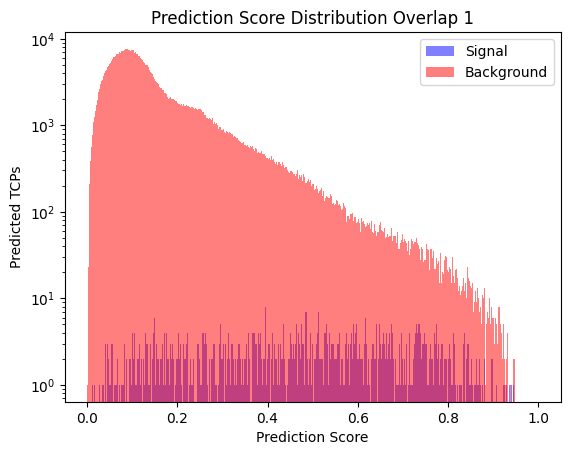

In [9]:
# Plotting Score
signal = []
background = []
overlap = 0
number_chunks = 20

Score(number_chunks, overlap, signal, background)
Score_plot(signal, background, overlap)

# ROC Plots

ROC plots help you compare the performance of different trainings, or the performanc of a given training in different regions (e.g Overlap)

In [10]:
# Functions definition
def ROC(total_chunks, l, truth, pred):
    # Loading DeepCore model and evaluation of ALL test files
    model.load_weights('DeepCore_model_0622.h5') # DeepCore 2.2
    # init counters
    N = 0
    Nx = 30 # X dimension
    Ny = 30 # Y dimension
   # Ntrk = 3 # Number of tracks
    s = 0 # s is the number of merged clusters that passed the selection (e.g: layer2(adc)> 0)

    #init the first chunk
    genObject = Generator2(testing_path,batch) 

    for n in range(total_chunks):
        chunk=next(genObject)
        [validation_par,validation_prob] = model.predict(chunk[0])
        validation_par = np.float64(validation_par)
        Ni = len(chunk[0][1])
        #print(Ni)
        N = N + Ni
        for i in range(Ni):
            A = np.array(chunk[0][0][i])
            S= np.sum(A, axis=(0,1))
            # Selection 
            if S[1] > 0 : # if sum of adc in layer2 is positive then ignore this merged cluster
           # if S[1] == 0 or S[3]> 0 or S[2]> 0:  # if sum of adc in layer2 is 0 or sum of adc in layer4 or layer3 is positive then ignore this merged cluster
           # if S[0]*S[2]*S[3]== 0: # if at least one of the sum of adc in layer1, layer3 or layer4 is 0, then ignore this merged cluster
                continue
            s = s +1
            for j in range(Nx):
                for k in range(Ny):
                    pixel_true_prob = chunk[1][1][i][j][k][l][0]
                    pixel_pred_prob = validation_prob[i,j,k,l,0]
                    truth.append(pixel_true_prob)
                    pred.append(pixel_pred_prob)
        
        if n%10 == 0: # Small print out to get an idea when this loop will be done running
            print("progress ", n*100/total_chunks, "%")
    print("Number of Merged clusters: ", N)
    print("Number of Merged clusters that pass our selection: ", s)
    print("Fraction: ", round(s*100/N,3), " %")

def ROC_plot(truth, pred, overlap):
    x = [0,1]
    fpr_keras, tpr_keras, _ = metrics.roc_curve(truth, pred)
    auc = np.trapz(tpr_keras,fpr_keras)

    plt.figure(1)
    plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc))
    plt.plot(x, x, color='red')  
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC Curve Overlap '+str(overlap+1)+'(area = {:.3f})'.format(auc))
    plt.savefig("ROC.png")
    plt.savefig("ROC.pdf")
    plt.show() 

progress  0.0 %
progress  50.0 %
Number of Merged clusters:  6598
Number of Merged clusters that pass our selection:  1246
Fraction:  18.885  %


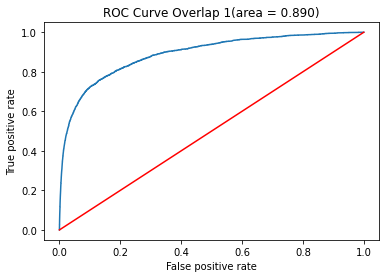

In [11]:
# Plotting ROC
truth = []
pred = []
overlap = 0
number_chunks = 20

ROC(number_chunks, overlap, truth, pred)
ROC_plot(truth, pred, overlap)

# Parameter Plots

In [8]:
def Parameter(total_chunks, par, l, bins_target, bins_pred):
    # Loading DeepCore model and evaluation of ALL test files
    model.load_weights('DeepCore_model_0622.h5') # DeepCore 2.2
    # init counters
    N = 0
    Nx = 30 # X dimension
    Ny = 30 # Y dimension
    #Ntrk = 3 # Number of tracks
    #init the first chunk
    genObject = Generator2(testing_path,batch) 
    # Prob thresholds
    prob_threshold = [0.7, 0.85, 1] 
    prob_dth_l134 = [0.1, 0.05, 0]
    prob_dth_l2 = [0.3, 0.15, 0]
    
    for n in range(total_chunks):
        chunk=next(genObject)
        [validation_par,validation_prob] = model.predict(chunk[0])
        validation_par = np.float64(validation_par)
        Ni = len(chunk[0][1])
        N = N + Ni
        for i in range(Ni):
            A = np.array(chunk[0][0][i])
            S= np.sum(A, axis=(0,1))
            dth_l134 = 1
            dth_l2 = 1
            if (S[0]*S[2]*S[3]): dth_l134 = 0 # checking if BPIX1 or 3 or 4 is empty
            if (S[1]): dth_l2 = 0 # checking if BPIX2 is empty
            for j in range(Nx):
                for k in range(Ny):
                   # for l in range(Ntrk):
                        pixel_true_prob = chunk[1][1][i][j][k][l][0]
                        pixel_pred_prob = validation_prob[i,j,k,l,0]
                        #if (pixel_pred_prob > (prob_threshold[l] + dth_l134*prob_dth_l134[l] + dth_l2*prob_dth_l2[l] )) and (pixel_true_prob == 1):
                        if (pixel_true_prob == 1):
                            if((par==0) or (par ==1)) : # dx or dy
                                #bins.append((validation_par[i,j,k,l,par] - chunk[1][0][i][j][k][l][par])*100)
                                bins_pred.append(validation_par[i,j,k,l,par]*100)
                                bins_target.append(chunk[1][0][i][j][k][l][par]*100)
                            elif((par==2) or (par ==3)) : # deta or dphi
                                #bins.append((validation_par[i,j,k,l,par] - chunk[1][0][i][j][k][l][par])*0.01)
                                bins_pred.append(validation_par[i,j,k,l,par]*0.01)
                                bins_target.append(chunk[1][0][i][j][k][l][par]*0.01)
                            else : #pt
                                #bins.append((validation_par[i,j,k,l,par] - chunk[1][0][i][j][k][l][par])/ chunk[1][0][i][j][k][l][par])  #relative
                                bins_pred.append(validation_par[i,j,k,l,par])
                                bins_target.append(chunk[1][0][i][j][k][l][par])

        if n%10 == 0: # Small print out to get an idea when this loop will be done running
            print("progress ", n*100/total_chunks, "%")
    print("Number of Merged clusters: ", N)


# Residual Plots
def residual_plots(par, bins):
    if(par== 0) :
        pylab.hist(bins,80,facecolor='darkorange',alpha=0.75,range=(-150,150))
        pylab.title('Residual Distribution - $\Delta x$',fontsize=22)
        # Plotting the mean and sd if needed
        #mean = np.array(bins).mean()
        #sigma = np.array(bins).std()
        #plt.text(80, 50000, "Mean =%.2f $\mu$m"%(mean), size=14) 
        #plt.text(80, 60000, "$\sigma_{\Delta x}$ = %.1f $\mu$m"%(sigma), size=14)
        # the tricky part is adjusting the height (50000 for the mean) every time you change statistics
        pylab.ylabel('TCP',fontsize=18)
        pylab.xlabel('Prediction-Target [$\mu$m]',fontsize=22)
        plt.grid(True)
    if(par == 1) :
        pylab.hist(bins,120, facecolor='darkorange',alpha=0.75,range=(-200,200))
        pylab.title('Residual Distribution - $\Delta y$',fontsize=22)
        #mean = np.array(bins).mean()
        #sigma = np.array(bins).std()
        #plt.text(100, 50000, "Mean =%.1f $\mu$m"%(mean), size=14)
        #plt.text(100, 60000, "$\sigma_{\Delta y}$ = %.1f $\mu$m"%(sigma), size=14)
        pylab.ylabel('TCP',fontsize=18)
        pylab.xlabel('Prediction-Target [$\mu$m]',fontsize=22)
        plt.grid(True)
    if(par== 2):
        pylab.hist(bins,100, facecolor='darkorange',alpha=0.75,range=(-0.02,0.02))
        pylab.title('Residual Distribution - $\Delta \eta$',fontsize=22)
        #mean = np.array(bins).mean()
        #sigma = np.array(bins).std()
        #plt.text(0.01, 130000, "Mean = 0", size=14)
        #plt.text(0.01, 150000, "$\sigma_{\Delta \eta}$ = %.3f"%(sigma), size=14)
        pylab.ylabel('TCP',fontsize=18)
        pylab.xlabel('Prediction-Target',fontsize=22)
        plt.grid(True)
    if(par == 3):
        pylab.hist(bins,100, facecolor='darkorange',alpha=0.75,range=(-0.02,0.02))
        pylab.title('Residual Distribution - $\Delta \phi$',fontsize=22)
        #mean = np.array(bins).mean()
        #sigma = np.array(bins).std()
        #plt.text(0.01, 80000, "Mean = 0", size=14)
        #plt.text(0.01, 90000, "$\sigma_{\Delta \phi}$ = %.3f"%(sigma), size=14)
        pylab.ylabel('TCP',fontsize=18)
        pylab.xlabel('Prediction-Target',fontsize=22)
        plt.grid(True)
    if (par == 4) :
        pylab.hist(bins,150, facecolor='darkorange', alpha=0.75,range=(-3,12))#range=(-0.2,0.2))#range=(-2,5)) #relative
        pylab.title('Residual Distribution - p_T$',fontsize=22)
        #mean = np.array(bins).mean()
        #sigma = np.array(bins).std()
        #plt.text(4, 28000, "Mean =%.1f"%(mean), size=14)
        #plt.text(4, 25000, "$\sigma_{\Delta(1/p_T)rel}$ = %.1f"%(sigma), size=14)
        pylab.ylabel('TCP',fontsize=18)
        pylab.xlabel('(Prediction-Target)/Target',fontsize=18) #only 1/pt
        plt.grid(True)
   # plt.figure()      

# Target Plots
def target_plots(par, bins, overlap):
    if(par == 0):
        pylab.hist(bins,100, facecolor='royalblue', alpha=0.75,range=(-100,100))
        pylab.title('$\Delta x$ Target Distribution Overlap '+ str(overlap+1),fontsize=22)
        pylab.xlabel('Target [$\mu$m]',fontsize=18)
        pylab.ylabel('TCP',fontsize=18)
        plt.grid(True)
    if(par == 1) :
        pylab.hist(bins,100, facecolor='royalblue', alpha=0.75,range=(-150,150))
        pylab.title('$\Delta y$ Target Distribution Overlap '+ str(overlap+1),fontsize=22)
        pylab.xlabel('Target [$\mu$m]',fontsize=18)
        pylab.ylabel('TCP',fontsize=18)
        plt.grid(True)
    if(par == 2) :
        pylab.hist(bins,90, facecolor='royalblue', alpha=0.75,range=(-0.04,0.04))
        pylab.title('$\Delta \eta$ Target Distribution Overlap '+ str(overlap+1),fontsize=22)
        pylab.xlabel('Target',fontsize=18)
        pylab.ylabel('TCP',fontsize=18)
        plt.grid(True)
    if(par == 3) :
        pylab.hist(bins,90, facecolor='royalblue', alpha=0.75,range=(-0.04,0.04))
        pylab.title('$\Delta \phi$ Target Distribution Overlap '+ str(overlap+1),fontsize=22)
        pylab.xlabel('Target',fontsize=18)
        pylab.ylabel('TCP',fontsize=18)
        plt.grid(True)
    if (par ==4):
        pylab.hist(bins,100, facecolor='royalblue',alpha=0.75,range=(0,200))
        pylab.title('$p_T$ Target Distribution Overlap '+ str(overlap+1),fontsize=22)
        pylab.xlabel('Target [GeV]',fontsize=18)
        pylab.ylabel('TCP',fontsize=18)
        plt.grid(False)
   # plt.figure()

# Prediction Plots
def pred_plots(par, bins,overlap):
    if(par == 0):
        pylab.hist(bins,80, facecolor='red', alpha=0.75,range=(-150,150))
        pylab.title('$\Delta x$ Prediction Distribution Overlap '+ str(overlap+1),fontsize=22)
        pylab.xlabel('Prediction [$\mu$m]',fontsize=18)
        pylab.ylabel('TCP',fontsize=18)
        plt.grid(True)
    if(par ==1) :
        pylab.hist(bins,120, facecolor='red', alpha=0.75,range=(-150,150))
        pylab.title('$\Delta y$ Prediction Distribution Overlap '+ str(overlap+1),fontsize=22)
        pylab.xlabel('Prediction [$\mu$m]',fontsize=18)
        pylab.ylabel('TCP',fontsize=18)
        plt.grid(True)
    if(par == 2) :
        pylab.hist(bins,70, facecolor='red', alpha=0.75,range=(-0.03,0.03))
        pylab.title('$\Delta \eta$ Prediction Distribution Overlap '+ str(overlap+1),fontsize=22)
        pylab.xlabel('Prediction',fontsize=18)
        pylab.ylabel('TCP',fontsize=18)
        plt.grid(True)
    if(par ==3 ) :
        pylab.hist(bins,70, facecolor='red', alpha=0.75,range=(-0.03,0.03))
        pylab.title('$\Delta \phi$ Prediction Distribution Overlap '+ str(overlap+1),fontsize=22)
        pylab.xlabel('Prediction',fontsize=18)
        pylab.ylabel('TCP',fontsize=18)
        plt.grid(True)
    if (par ==4) :
        pylab.hist(bins,100, facecolor='red',alpha=0.75,range=(0,200))
        pylab.title('$p_T$ Prediction Distribution Overlap '+ str(overlap+1),fontsize=22)
        pylab.xlabel('Prediction [GeV]',fontsize=18)
        pylab.ylabel('TCP',fontsize=18)
        plt.grid(True)
    #plt.figure()
        
# Scatter Plots
def scatter_plots(par, bins_x, bins_y, overlap):
    if(par == 0) :
        nx = 100
        plt.hist2d(bins_x, bins_y,bins=nx,range= [[-nx,nx], [-nx, nx]], cmap=plt.cm.viridis)#, marker='+')
        # Plotting diagonal
        l_x = [-150, 150]
        plt.plot(l_x, l_x, color='black') 
        pylab.title('$\Delta x$ Prediction vs Target Overlap '+ str(overlap+1),fontsize=22)
        plt.ylabel('Predicted $\Delta x$ [$\mu$m]', fontsize=18)
        plt.xlabel('Target $\Delta x$ [$\mu$m]', fontsize=18)
        plt.colorbar()
        plt.grid(False)
    if(par == 1) :
        ny = 150
        plt.hist2d(bins_x,bins_y,bins=ny,range= [[-ny,ny], [-ny, ny]], cmap=plt.cm.viridis)
        # Plotting diagonal
        l_y = [-225,225]
        plt.plot(l_y, l_y, color='black') 
        pylab.title('$\Delta y$ Prediction vs Target Overlap '+ str(overlap+1),fontsize=22)
        plt.ylabel('Predicted $\Delta y$ [$\mu$m]', fontsize=18)
        plt.xlabel('Target $\Delta y$ [$\mu$m]', fontsize=18)
        # Plotting other lines
        #l_pt = [-75,75]
        #l_zero = [0,0]
        #l_1 = [10,10]
        #l_2 = [-10,-10]
        #plt.plot(l_pt, l_pt, color='black') 
        #plt.plot(l_pt, l_1, color='black', linestyle='dashed') 
        #plt.plot(l_pt, l_2, color='black', linestyle='dashed')
        #plt.plot(l_pt, l_zero, color='black', linestyle='dashed') 
        plt.colorbar()
        plt.grid(False)
    if(par == 2) :
        plt.hist2d(bins_x,bins_y,bins=180,range = [[-0.03,0.03], [-0.03, 0.03]], cmap=plt.cm.viridis)
        # Plotting diagonal
        l_eta = [-0.04,0.04]
        plt.plot(l_eta, l_eta, color='black') 
        pylab.title('$\Delta \eta$ Prediction vs Target Overlap '+ str(overlap+1),fontsize=22)
        plt.ylabel('Predicted $\Delta \eta$ ', fontsize=18)
        plt.xlabel('Target $\Delta \eta$', fontsize=18)
        plt.colorbar()
        plt.grid(False)
    if(par == 3) :
        plt.hist2d(bins_x,bins_y,bins=180,range = [[-0.03,0.03], [-0.03, 0.03]], cmap=plt.cm.viridis)
        # Plotting diagonal
        l_phi = [-0.04,0.04]
        plt.plot(l_phi, l_phi, color='black') 
        pylab.title('$\Delta \phi$ Prediction vs Target Overlap '+ str(overlap+1),fontsize=22)
        plt.ylabel('Predicted $\Delta \phi$', fontsize=18)
        plt.xlabel('Target $\Delta \phi$', fontsize=18)
        plt.colorbar()
        plt.grid(False)
    if(par == 4) :
        plt.hist2d(bins_x,bins_y,bins=100,range= [[0,200], [0, 200]])
        # Plotting diagonal
        l_pt = [0, 200]
        #l_zero = [0,0]
        plt.plot(l_pt, l_pt, color='black') 
        #plt.plot(l_zero, l_pt, color='black', linestyle='dashed') 
        #plt.plot(l_pt, l_zero, color='black', linestyle='dashed') 
        pylab.title('$p_T$ Prediction vs Target Overlap '+ str(overlap+1),fontsize=22)
        plt.ylabel('Predicted $p_T$ [GeV]', fontsize=18)
        plt.xlabel('Target $p_T$ [GeV]', fontsize=18)
        plt.colorbar()
        plt.grid(False)
 

In [13]:
# param plots
pred_param = []
target_param = []
param = 1 # dx = 0; dy =1; deta = 2; dphi = 3; pt = 4
overlap = 0
number_chunks = 20

Parameter(number_chunks, overlap, param, target_param, pred_param)

progress  0.0 %
progress  50.0 %
Number of Merged clusters:  6598


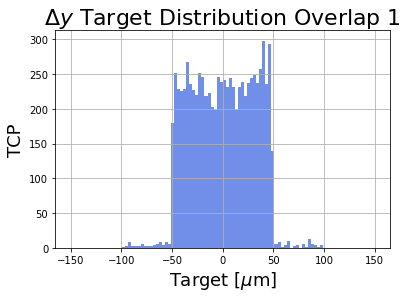

In [14]:
# Target distribution
target_plots(param,target_param, overlap)

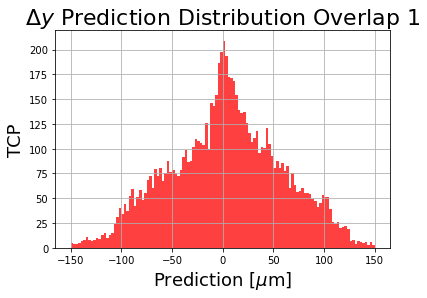

In [15]:
# Predicted distribution
pred_plots(param,pred_param, overlap)

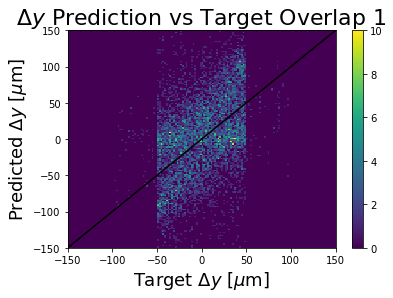

In [16]:
# Scatter plot
scatter_plots(param, target_param, pred_param, overlap)

# Small stats: All plots + TCP Maps
If you want to run on a small subset of the testing samples, you can run the cells below.

I would also recommend starting here if you're trying to familiarize yourself with the notebook

In [8]:
# Loading DeepCore model and evaluation on small stats
batch = 3800 # You may increase the number of Merged clusters up to 3800
inputs = []
chunk = next(Generator2(testing_path,batch)) 
#chunk = next(Generator2(testing_path,batch,))
#inputs.append(chunk[0])

## Importing model
#model.load_weights('Valerio_model.hdf5') # DeepCore 1.0
#model.load_weights('DeepCore_model_1017.h5') # DeepCore 2.0
#model.load_weights('DeepCore_model_23_0214_40.h5') DeepCore 2.1
model.load_weights('/Users/liamoshaughnessy/Desktop/Research_2023_2024/Code/Python_Files/Semester_1/DeepCore_model_0622.h5') # DeepCore 2.2
#model.summary()

## Making all the predictions
[validation_par,validation_prob] = model.predict(chunk[0])
validation_par = np.float64(validation_par)

119/119 [==============================] - 19s 162ms/step


# DeepCore Notebook Printouts

The format of the prediction arrays are as follow: 

1) validation_prob[merged_cluster, x,  y, track, [probability, fake probability]]

2) validation_par[merged_cluster, x,  y, track, [dx, dy, deta, dphi, 1/pt, zero_flag]] 

- Your inputs are merged cluster --> N

- Your image size is x = 30 by y = 30.

- For every pixel (30*30 = 900) in every merged cluster there are 3 predicted tracks so track = 3.

- For every predicted track in every pixel of every merged cluster, you have a prediction score in validation_prob (how likely that a particle crossed this pixel) and predicted parameters in validation_par (dx, dy, deta, dphi, 1/pt). Please ignore "fake probability" and "zero_flag".

If this is a bit confusing, I've included a few useful print outs below to convince yourself of this format:

In [18]:
# Debugging printouts
print(validation_prob.shape) # (merged cluster, x, y, track, prediction)
print(validation_par.shape) # 5 predicted track param and predicted zero flag
#print(validation_prob)
#print(validation_prob[0]) # prints out everything for input 0 (1st merged hit)
#print(validation_prob[0,0,0]) # prints out everything for input 0 (1st merged hit) and x = y = 0
#print(validation_prob[0,0,0,0]) # prints out everything for input 0 (1st merged hit) and x = y = track = 0
#print(validation_prob[0,0,0,0,0]) # prints prediction (ignore 2nd prediction since it's softmax) for input 0 and x = y = track = 0

(3800, 30, 30, 3, 2)
(3800, 30, 30, 3, 6)


The format of the target/truth information has similar formatting to the prediction, but it included in the Training sample input array, which also contains the CNN input information.

For DeepCore to make a prediction, it requires this input information for every merged cluster: the charge deposit on every pixel of every layer (30 x 30 x4), jet pt and jet eta.

The target information is included in chunk[1], while the input information is included in chunk[0]. 

- Target Track Parameters: chunk[1][0][merged_cluster][x][y][track][dx,dy,deta,dphi,1/pt,prob_flag] (ignore "prob_flag").

- Target Track Score: chunk[1][1][merged_cluster][x][y][track][target_score] (1 if a particle crossed a pixel, 0 otherwise).

- Merged cluster charge deposit: chunk[0][0][merged_cluster][x][y][layer] (4 layers)

- Merged cluster jet eta: chunk[0][1][merged_cluster]

- Merged cluster jet pt: chunk[0][2][merged_cluster]

 I've included a few useful print outs below:

In [19]:
# Debugging printouts
#print(chunk[1][0][0][0][0][0][0]) # prints target parameter dx for 1st merged cluster and x = y = track = 0
#print(chunk[1][1][0][0][0][0][0]) # prints target score (0 or 1) for 1st merged cluster and x = y = track = 0
#print(chunk[0][0][0][0][0][1]) # prints charge deposit in a pixel on layer 2 for 1st Merged cluster and x = y = 0 
#print(chunk[0][1][1]) # print jet eta of 2nd merged cluster

A couple more print outs for fun

In [20]:
# Debugging printouts: Printing prediction, target probility and track number if target = 1
N = 10
print("merged cluster, x, y,   pred score, true dx,  true dy, true deta, true dphi, true 1/pt")
for i in range(N): # loop over input
    for j in range(30): # loop over x
        for k in range(30): # loop over y
            for l in range(3) : # loop over tracks
                if chunk[1][1][i][j][k][l][0] ==1 and validation_prob[i,j,k,l,0]>0.8:
                    print("    ",i,"        ", j, k, "  ", round(validation_prob[i,j,k,l,0],4),"  ", round(chunk[1][0][i][j][k][l][0],4),"  ", round(chunk[1][0][i][j][k][l][1], 4),"  ", round(chunk[1][0][i][j][k][l][2], 4) ,"  ", round(chunk[1][0][i][j][k][l][3],4) ,"  ", round(chunk[1][0][i][j][k][l][4],4) )
                    

merged cluster, x, y,   pred score, true dx,  true dy, true deta, true dphi, true 1/pt
     0          11 15    0.9662    0.1102    0.607    -0.1804    0.529    132.3659
     0          15 15    0.9763    0.3961    0.1303    -0.1095    -0.2184    32.9679
     0          15 16    0.9812    -0.209    0.4486    -0.3578    0.0539    60.8948
     0          18 13    0.9886    -0.2669    -0.0483    0.328    -0.7144    13.9073
     1          11 16    0.9733    0.1102    0.607    -0.3327    0.6101    132.3659
     1          15 16    0.9873    0.3961    0.1303    -0.2618    -0.1373    32.9679
     1          15 17    0.9873    -0.209    0.4486    -0.51    0.1351    60.8948
     1          18 14    0.9871    -0.2669    -0.0483    0.1758    -0.6333    13.9073
     2          7 16    0.9725    -0.3426    0.2324    -0.2684    1.0777    7.2779
     2          7 16    0.9743    -0.3426    0.2324    -0.2684    1.0777    7.2779
     2          9 16    0.9732    0.1785    0.0824    -0.2263    1.0648  

In [21]:
# Debugging printouts: Printing prediction, target probility and track number if target = 1
N = 2
for i in range(N): # loop over input
    for j in range(30): # loop over x
        for k in range(30): # loop over y
            for l in range(1) : # loop over tracks
                # TCP
                pixel_true_prob = chunk[1][1][i][j][k][l][0]
                pixel_pred_prob = validation_prob[i,j,k,l,0]
                # True TP
                pixel_true_dx = chunk[1][0][i][j][k][l][0]
                pixel_true_dy = chunk[1][0][i][j][k][l][1]
                pixel_true_deta = chunk[1][0][i][j][k][l][2]
                pixel_true_dphi = chunk[1][0][i][j][k][l][3]
                pixel_true_invpt = chunk[1][0][i][j][k][l][4]
                # Predicted TP
                pixel_pred_dx = validation_par[i,j,k,l,0]
                pixel_pred_dy = validation_par[i,j,k,l,1]
                pixel_pred_deta = validation_par[i,j,k,l,2]
                pixel_pred_dphi = validation_par[i,j,k,l,3]
                pixel_pred_invpt = validation_par[i,j,k,l,4]
                # merged cluster inputs (layer 2)
                pixel_lay2_adc = chunk[0][0][i][j][k][1]
                merged_cluster_eta = chunk[0][1][i]
                merged_cluster_pt = chunk[0][2][i]
                if pixel_true_prob ==1: 
                    print("Pixel (",j,",",k,"): True     vs   Predicted")
                    print("     Probability:",  round(pixel_true_prob,3), "     vs ", pixel_pred_prob )
                    print("              dx: ",  round(pixel_true_dx,3), " vs ",  round(pixel_pred_dx, 3) )
                    print("              dy: ",  round(pixel_true_dy,3), " vs ",  round(pixel_pred_dy, 3) )
                    print("            deta: ",  round(pixel_true_deta,3), " vs ",  round(pixel_pred_deta, 3) )
                    print("            dphi: ",  round(pixel_true_dphi,3), " vs ",  round(pixel_pred_dphi, 3) )
                    print("            1/pt: ",  round(pixel_true_invpt,3), " vs ",  round(pixel_pred_invpt, 3) )
                    print(merged_cluster_pt)

Pixel ( 11 , 15 ): True     vs   Predicted
     Probability: 1.0      vs  0.9661803
              dx:  0.11  vs  0.417
              dy:  0.607  vs  0.13
            deta:  -0.18  vs  -0.04
            dphi:  0.529  vs  0.44
            1/pt:  132.366  vs  84.7
1802.3621826171875
Pixel ( 15 , 15 ): True     vs   Predicted
     Probability: 1.0      vs  0.976262
              dx:  0.396  vs  0.352
              dy:  0.13  vs  0.074
            deta:  -0.11  vs  -0.077
            dphi:  -0.218  vs  0.002
            1/pt:  32.968  vs  264.505
1802.3621826171875
Pixel ( 15 , 16 ): True     vs   Predicted
     Probability: 1.0      vs  0.98119736
              dx:  -0.209  vs  0.003
              dy:  0.449  vs  -0.146
            deta:  -0.358  vs  -0.247
            dphi:  0.054  vs  -0.123
            1/pt:  60.895  vs  261.83
1802.3621826171875
Pixel ( 18 , 13 ): True     vs   Predicted
     Probability: 1.0      vs  0.9885608
              dx:  -0.267  vs  -0.22
              dy:  -0

# Score plots and ROC plots

In [22]:
# Score+ROC plotter loop
# Signal is true tracks with predictions, background is when there is a prediction for a track that does not exist (fake)
signal = []
signal_target = []
background = []

signal_lay2 = []
background_lay2 = []

signal_lay2_0 = []
background_lay2_0 = []

truth = []
pred = []

N = batch # number of inputs
Nx = 30 # X dimension
Ny = 30 # Y dimension
Ntrk = 3 # Number of tracks
ble = 0
tot = 0
#l = 2

for i in range(N-1):
    A = np.array(chunk[0][0][i])
    S= np.sum(A, axis=(0,1))
    SS = S[1]
    #merged_cluster_eta = chunk[0][1][i]
    #if merged_cluster_eta > 0.4:
    #    ble = ble + 1
    #    continue
    #SS = S[0]+S[1]+S[2]+S[3]
    if SS > 0 :
    #    ble = ble + 1
        continue
    for j in range(Nx):
        for k in range(Ny):
            for l in range(Ntrk) :
                l = 0    #to look at Overlap maps, just set l = 0/1/2 here
                pixel_true_prob = chunk[1][1][i][j][k][l][0]
                pixel_pred_prob = validation_prob[i,j,k,l,0]
                pixel_lay2_adc = chunk[0][0][i][j][k][1]
                truth.append(pixel_true_prob)
                pred.append(pixel_pred_prob)
                #pred.append(validation_prob[i,j,k,l,0]/(validation_prob[i,j,k,l,0]+validation_prob[i,j,k,l,1]))
                #if  pixel_lay2_adc ==0:
                #    continue
                if pixel_true_prob ==1 :
                    signal.append(pixel_pred_prob)
                    #if SS > 0:
                    #    signal_lay2.append(validation_prob[i,j,k,l,0])
                    #else:
                    #    signal_lay2_0.append(validation_prob[i,j,k,l,0])
                    #signal_target.append(chunk[1][0][i][j][k][l][:5])
                    #signal.append(validation_prob[i,j,k,l,0]/(validation_prob[i,j,k,l,0]+validation_prob[i,j,k,l,1]))
                    
                else:
                    background.append(pixel_pred_prob)
                    #if SS > 0:
                    #    background_lay2.append(validation_prob[i,j,k,l,0])
                    #else:
                    #    background_lay2_0.append(validation_prob[i,j,k,l,0])
                    #background.append(validation_prob[i,j,k,l,0]/(validation_prob[i,j,k,l,0]+validation_prob[i,j,k,l,1]))
                    

IndexError: index 3788 is out of bounds for axis 0 with size 3788

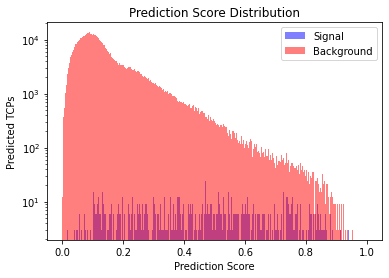

In [23]:
# Plotting Prediction Score Distribution (log, not normalized): recommended
bin_size = 1000
#bin_size = 50
plt.hist(signal, alpha = 0.5, color = 'b', label = 'Signal', range = (0,1), bins = bin_size) #, density = True)
plt.hist(background, color = 'r', alpha = 0.5, label = 'Background', range = (0,1), bins = bin_size) #, density = True)
plt.legend(loc='best')
plt.xlabel('Prediction Score')
plt.ylabel('Predicted TCPs')
plt.yscale('log')
plt.title('Prediction Score Distribution')
plt.show()

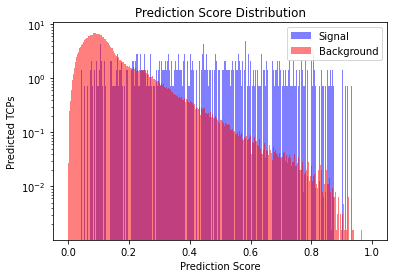

In [24]:
# Plotting Prediction Score Distribution (normalized): misleading but useful to compare discrimination power of models
bin_size = 1000
#bin_size = 50
plt.hist(signal, alpha = 0.5, color = 'b', label = 'Signal', range = (0,1), bins = bin_size, density = True)
plt.hist(background, color = 'r', alpha = 0.5, label = 'Background', range = (0,1), bins = bin_size, density = True)
plt.legend(loc='best')
plt.xlabel('Prediction Score')
plt.ylabel('Predicted TCPs')
plt.yscale('log')
plt.title('Prediction Score Distribution')
plt.show()

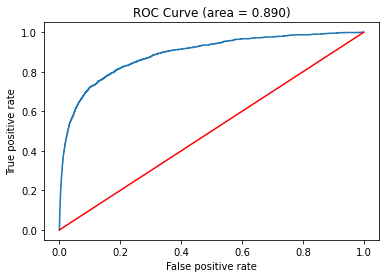

In [25]:
#Plotting ROC curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn import metrics

x = [0,1]

fpr_keras, tpr_keras, _ = metrics.roc_curve(truth, pred)
auc = np.trapz(tpr_keras,fpr_keras)
#print auc

plt.figure(1)
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc))
plt.plot(x, x, color='red')  
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve (area = {:.3f})'.format(auc))
plt.savefig("ROC.png")
plt.savefig("ROC.pdf")
plt.show() 

In [10]:
# Score plots with adc = or > 0 cut given layer and overlap: Useful to look at score plots as a function of Overlap and zero-adc layers
def score_plot_lay_pos(lay, overlap):
    signal = []
    background = []
    N = batch # number of inputs
    Nx = 30 # X dimension
    Ny = 30 # Y dimension
    l = overlap
    frac = 0
    
    for i in range(N):
        A = np.array(chunk[0][0][i])
        S= np.sum(A, axis=(0,1))
        SS = S[lay]
        if SS == 0 :
            continue
        frac = frac + 1
        for j in range(Nx):
            for k in range(Ny):
                pixel_true_prob = chunk[1][1][i][j][k][l][0]
                pixel_pred_prob = validation_prob[i,j,k,l,0]
                if pixel_true_prob ==1:
                    signal.append(pixel_pred_prob)
                else:
                    background.append(pixel_pred_prob)
   
    bin_size = 1000
    plt.hist(signal, alpha = 0.5, color = 'b', label = 'Signal', range = (0,1), bins = bin_size) #, density = True)
    plt.hist(background, color = 'r', alpha = 0.5, label = 'Background', range = (0,1), bins = bin_size) #, density = True)
    plt.legend(loc='best')
    plt.xlabel('Prediction Score')
    plt.ylabel('Pixels')
    plt.yscale('log')
    s = 'Distribution of Overlap ' + str(l+1) + ' with $\Sigma$adc(layer '+ str(lay+1) + ') > 0 (f=' + str(round((100*frac)/N,1))+ '%)'
    plt.title(s)
    plt.show()
    
def score_plot_lay_zero(lay, overlap):
    signal = []
    background = []
    N = batch # number of inputs
    Nx = 30 # X dimension
    Ny = 30 # Y dimension
    l = overlap
    frac = 0

    for i in range(N):
        A = np.array(chunk[0][0][i])
        S= np.sum(A, axis=(0,1))
        SS = S[lay]
        if SS > 0 :
            continue
        frac = frac + 1
        for j in range(Nx):
            for k in range(Ny):
                pixel_true_prob = chunk[1][1][i][j][k][l][0]
                pixel_pred_prob = validation_prob[i,j,k,l,0]
                if pixel_true_prob ==1:
                    signal.append(pixel_pred_prob)
                else:
                    background.append(pixel_pred_prob)
   
    bin_size = 1000
    plt.hist(signal, alpha = 0.5, color = 'b', label = 'Signal', range = (0,1), bins = bin_size) #, density = True)
    plt.hist(background, color = 'r', alpha = 0.5, label = 'Background', range = (0,1), bins = bin_size) #, density = True)
    plt.legend(loc='best')
    plt.xlabel('Prediction Score')
    plt.ylabel('Pixels')
    plt.yscale('log')
    s = 'Distribution of Overlap ' + str(l+1) + ' with $\Sigma$adc(layer '+ str(lay+1) + ') = 0 (f=' + str(round((100*frac)/N,1))+ '%)'
    plt.title(s)
    plt.show()

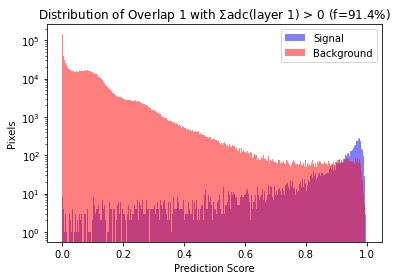

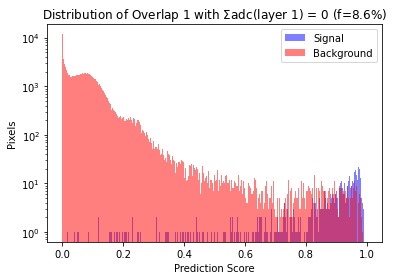

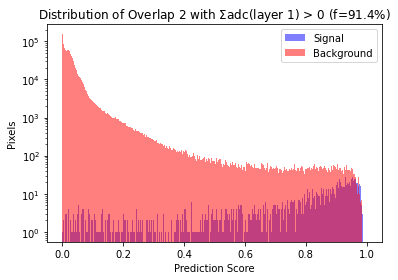

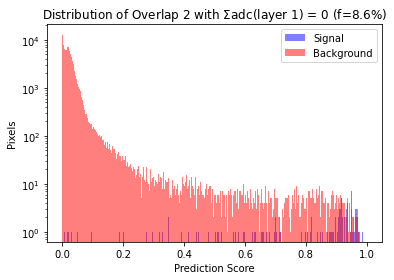

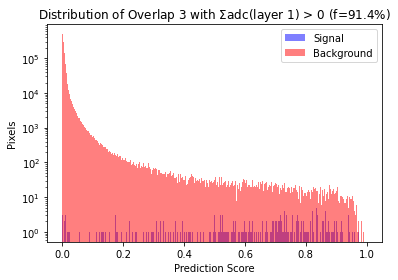

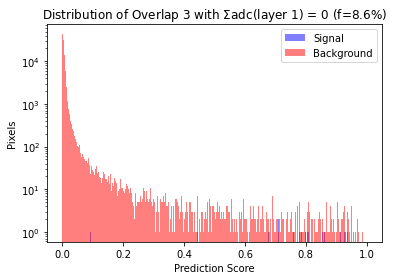

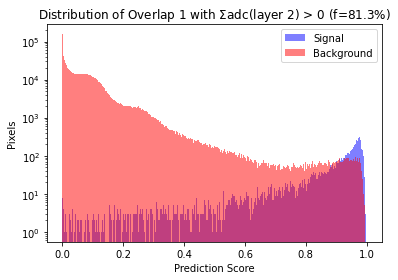

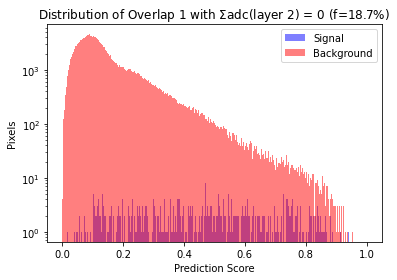

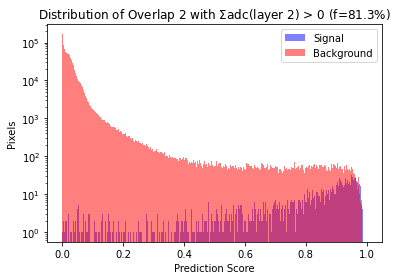

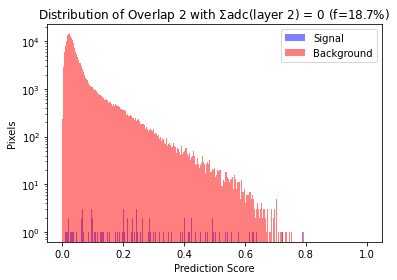

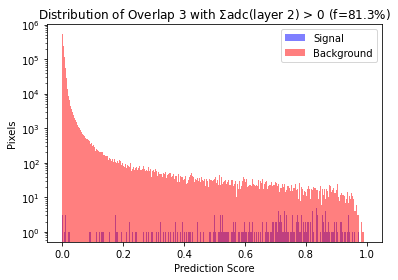

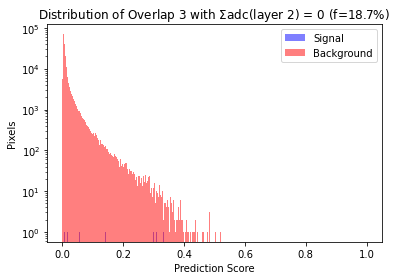

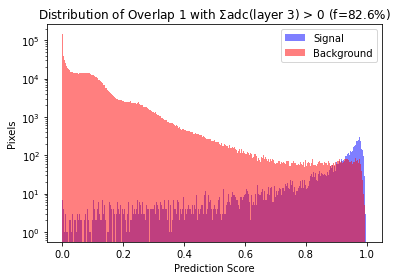

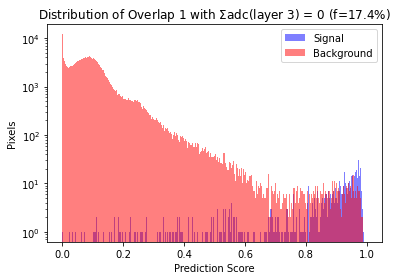

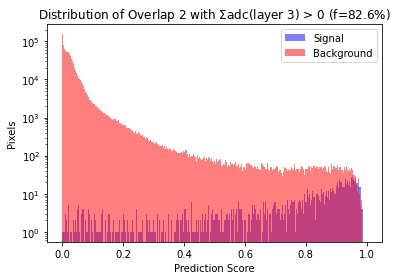

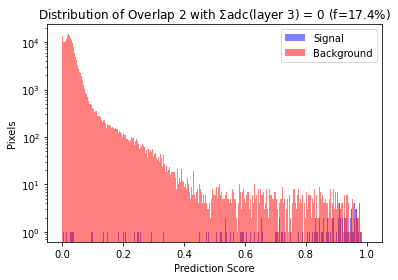

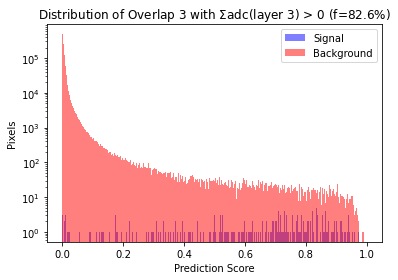

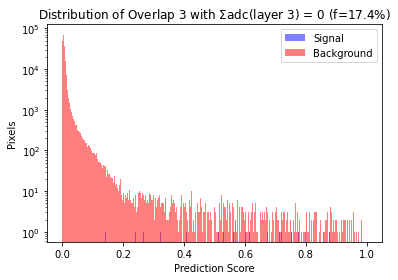

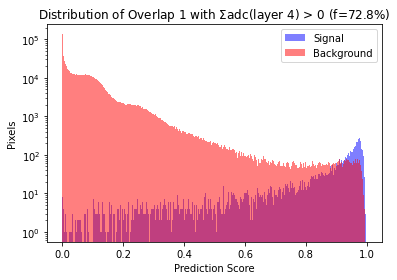

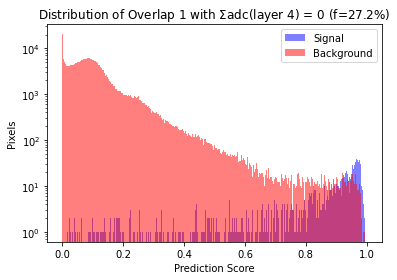

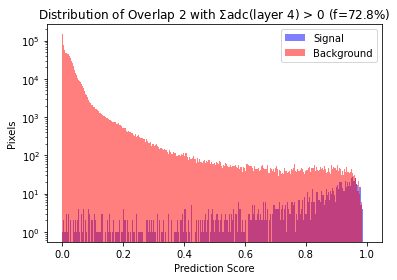

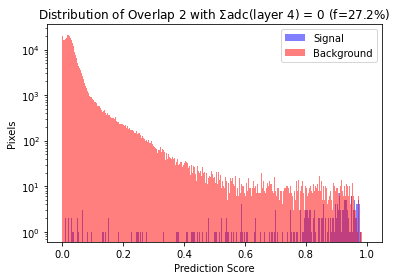

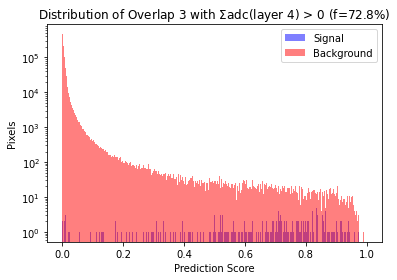

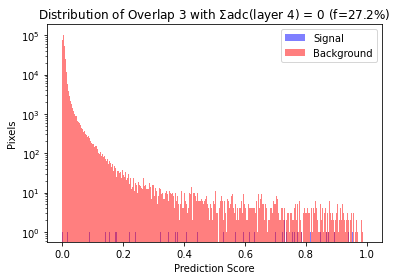

In [27]:
for lay in range(0,4):
    for overlap in range(0,3):
        score_plot_lay_pos(lay, overlap)
        score_plot_lay_zero(lay, overlap)

# Parameter Plots

In [9]:
# DeepCore 2.2.1 Param plots definition and set up

# Residual Plots
def residual_plots(par, bins):
    if(par== 0) :
        pylab.hist(bins,80,facecolor='darkorange',alpha=0.75,range=(-150,150))
        pylab.title('Residual Distribution - $\Delta x$',fontsize=22)
        # Plotting the mean and sd if needed
        #mean = np.array(bins).mean()
        #sigma = np.array(bins).std()
        #plt.text(80, 50000, "Mean =%.2f $\mu$m"%(mean), size=14) 
        #plt.text(80, 60000, "$\sigma_{\Delta x}$ = %.1f $\mu$m"%(sigma), size=14)
        # the tricky part is adjusting the height (50000 for the mean) every time you change statistics
        pylab.ylabel('TCP',fontsize=18)
        pylab.xlabel('Prediction-Target [$\mu$m]',fontsize=22)
        plt.grid(True)
    if(par == 1) :
        pylab.hist(bins,120, facecolor='darkorange',alpha=0.75,range=(-200,200))
        pylab.title('Residual Distribution - $\Delta y$',fontsize=22)
        #mean = np.array(bins).mean()
        #sigma = np.array(bins).std()
        #plt.text(100, 50000, "Mean =%.1f $\mu$m"%(mean), size=14)
        #plt.text(100, 60000, "$\sigma_{\Delta y}$ = %.1f $\mu$m"%(sigma), size=14)
        pylab.ylabel('TCP',fontsize=18)
        pylab.xlabel('Prediction-Target [$\mu$m]',fontsize=22)
        plt.grid(True)
    if(par== 2):
        pylab.hist(bins,100, facecolor='darkorange',alpha=0.75,range=(-0.02,0.02))
        pylab.title('Residual Distribution - $\Delta \eta$',fontsize=22)
        #mean = np.array(bins).mean()
        #sigma = np.array(bins).std()
        #plt.text(0.01, 130000, "Mean = 0", size=14)
        #plt.text(0.01, 150000, "$\sigma_{\Delta \eta}$ = %.3f"%(sigma), size=14)
        pylab.ylabel('TCP',fontsize=18)
        pylab.xlabel('Prediction-Target',fontsize=22)
        plt.grid(True)
    if(par == 3):
        pylab.hist(bins,100, facecolor='darkorange',alpha=0.75,range=(-0.02,0.02))
        pylab.title('Residual Distribution - $\Delta \phi$',fontsize=22)
        #mean = np.array(bins).mean()
        #sigma = np.array(bins).std()
        #plt.text(0.01, 80000, "Mean = 0", size=14)
        #plt.text(0.01, 90000, "$\sigma_{\Delta \phi}$ = %.3f"%(sigma), size=14)
        pylab.ylabel('TCP',fontsize=18)
        pylab.xlabel('Prediction-Target',fontsize=22)
        plt.grid(True)
    if (par == 4) :
        pylab.hist(bins,150, facecolor='darkorange', alpha=0.75,range=(-3,12))#range=(-0.2,0.2))#range=(-2,5)) #relative
        pylab.title('Residual Distribution - p_T$',fontsize=22)
        #mean = np.array(bins).mean()
        #sigma = np.array(bins).std()
        #plt.text(4, 28000, "Mean =%.1f"%(mean), size=14)
        #plt.text(4, 25000, "$\sigma_{\Delta(1/p_T)rel}$ = %.1f"%(sigma), size=14)
        pylab.ylabel('TCP',fontsize=18)
        pylab.xlabel('(Prediction-Target)/Target',fontsize=18) #only 1/pt
        plt.grid(True)
   # plt.figure()      

# Target Plots
def target_plots(par, bins):
    if(par == 0):
        pylab.hist(bins,100, facecolor='royalblue', alpha=0.75,range=(-100,100))
        pylab.title('Target Distribution - $\Delta x$',fontsize=22)
        pylab.xlabel('Target [$\mu$m]',fontsize=18)
        pylab.ylabel('TCP',fontsize=18)
        plt.grid(True)
    if(par == 1) :
        pylab.hist(bins,100, facecolor='royalblue', alpha=0.75,range=(-150,150))
        pylab.title('Target Distribution - $\Delta y$',fontsize=22)
        pylab.xlabel('Target [$\mu$m]',fontsize=18)
        pylab.ylabel('TCP',fontsize=18)
        plt.grid(True)
    if(par == 2) :
        pylab.hist(bins,90, facecolor='royalblue', alpha=0.75,range=(-0.04,0.04))
        pylab.title('Target Distribution - $\Delta \eta$',fontsize=22)
        pylab.xlabel('Target',fontsize=18)
        pylab.ylabel('TCP',fontsize=18)
        plt.grid(True)
    if(par == 3) :
        pylab.hist(bins,90, facecolor='royalblue', alpha=0.75,range=(-0.04,0.04))
        pylab.title('Target Distribution - $\Delta \phi$',fontsize=22)
        pylab.xlabel('Target',fontsize=18)
        pylab.ylabel('TCP',fontsize=18)
        plt.grid(True)
    if (par ==4):
        pylab.hist(bins,100, facecolor='royalblue',alpha=0.75,range=(0,200))
        pylab.title('Target Distribution - $p_T$',fontsize=22)
        pylab.xlabel('Target [GeV]',fontsize=18)
        pylab.ylabel('TCP',fontsize=18)
        plt.grid(False)
   # plt.figure()

# Prediction Plots
def pred_plots(par, bins):
    if(par == 0):
        pylab.hist(bins,80, facecolor='red', alpha=0.75,range=(-150,150))
        pylab.title('Prediction Distribution - $\Delta x$',fontsize=22)
        pylab.xlabel('Prediction [$\mu$m]',fontsize=18)
        pylab.ylabel('TCP',fontsize=18)
        plt.grid(True)
    if(par ==1) :
        pylab.hist(bins,120, facecolor='red', alpha=0.75,range=(-150,150))
        pylab.title('Prediction Distribution - $\Delta y$',fontsize=22)
        pylab.xlabel('Prediction [$\mu$m]',fontsize=18)
        pylab.ylabel('TCP',fontsize=18)
        plt.grid(True)
    if(par == 2) :
        pylab.hist(bins,70, facecolor='red', alpha=0.75,range=(-0.03,0.03))
        pylab.title('Prediction Distribution - $\Delta \eta$',fontsize=22)
        pylab.xlabel('Prediction',fontsize=18)
        pylab.ylabel('TCP',fontsize=18)
        plt.grid(True)
    if(par ==3 ) :
        pylab.hist(bins,70, facecolor='red', alpha=0.75,range=(-0.03,0.03))
        pylab.title('Prediction Distribution - $\Delta \phi$',fontsize=22)
        pylab.xlabel('Prediction',fontsize=18)
        pylab.ylabel('TCP',fontsize=18)
        plt.grid(True)
    if (par ==4) :
        pylab.hist(bins,100, facecolor='red',alpha=0.75,range=(0,200))
        pylab.title('Prediction Distribution - $p_T$',fontsize=22)
        pylab.xlabel('Prediction [GeV]',fontsize=18)
        pylab.ylabel('TCP',fontsize=18)
        plt.grid(True)
    #plt.figure()
        
# Scatter Plots
def scatter_plots(par, bins_x, bins_y):
    if(par == 0) :
        nx = 100
        plt.hist2d(bins_x, bins_y,bins=nx,range= [[-nx,nx], [-nx, nx]], cmap=plt.cm.viridis)#, marker='+')
        # Plotting diagonal
        l_x = [-150, 150]
        plt.plot(l_x, l_x, color='black') 
        pylab.title('Prediction vs Target - $\Delta x$',fontsize=22)
        plt.ylabel('Predicted $\Delta x$ [$\mu$m]', fontsize=18)
        plt.xlabel('Target $\Delta x$ [$\mu$m]', fontsize=18)
        plt.colorbar()
        plt.grid(False)
    if(par == 1) :
        ny = 150
        plt.hist2d(bins_x,bins_y,bins=ny,range= [[-ny,ny], [-ny, ny]], cmap=plt.cm.viridis)
        # Plotting diagonal
        l_y = [-225,225]
        plt.plot(l_y, l_y, color='black') 
        pylab.title('Prediction vs Target - $\Delta y$',fontsize=22)
        plt.ylabel('Predicted $\Delta y$ [$\mu$m]', fontsize=18)
        plt.xlabel('Target $\Delta y$ [$\mu$m]', fontsize=18)
        # Plotting other lines
        #l_pt = [-75,75]
        #l_zero = [0,0]
        #l_1 = [10,10]
        #l_2 = [-10,-10]
        #plt.plot(l_pt, l_pt, color='black') 
        #plt.plot(l_pt, l_1, color='black', linestyle='dashed') 
        #plt.plot(l_pt, l_2, color='black', linestyle='dashed')
        #plt.plot(l_pt, l_zero, color='black', linestyle='dashed') 
        plt.colorbar()
        plt.grid(False)
    if(par == 2) :
        plt.hist2d(bins_x,bins_y,bins=180,range = [[-0.03,0.03], [-0.03, 0.03]], cmap=plt.cm.viridis)
        # Plotting diagonal
        l_eta = [-0.04,0.04]
        plt.plot(l_eta, l_eta, color='black') 
        pylab.title('Prediction vs Target - $\Delta \eta$',fontsize=22)
        plt.ylabel('Predicted $\Delta \eta$ ', fontsize=18)
        plt.xlabel('Target $\Delta \eta$', fontsize=18)
        plt.colorbar()
        plt.grid(False)
    if(par == 3) :
        plt.hist2d(bins_x,bins_y,bins=180,range = [[-0.03,0.03], [-0.03, 0.03]], cmap=plt.cm.viridis)
        # Plotting diagonal
        l_phi = [-0.04,0.04]
        plt.plot(l_phi, l_phi, color='black') 
        pylab.title('Prediction vs Target - $\Delta \phi$',fontsize=22)
        plt.ylabel('Predicted $\Delta \phi$', fontsize=18)
        plt.xlabel('Target $\Delta \phi$', fontsize=18)
        plt.colorbar()
        plt.grid(False)
    if(par == 4) :
        plt.hist2d(bins_x,bins_y,bins=100,range= [[0,200], [0, 200]])
        # Plotting diagonal
        l_pt = [0, 200]
        #l_zero = [0,0]
        plt.plot(l_pt, l_pt, color='black') 
        #plt.plot(l_zero, l_pt, color='black', linestyle='dashed') 
        #plt.plot(l_pt, l_zero, color='black', linestyle='dashed') 
        pylab.title('Prediction vs Target - $p_T$',fontsize=22)
        plt.ylabel('Predicted $p_T$ [GeV]', fontsize=18)
        plt.xlabel('Target $p_T$ [GeV]', fontsize=18)
        plt.colorbar()
        plt.grid(False)


    

In [10]:
# Param plotter loop

parNum = 5 # TP
N = len(chunk[0][0]) # Merged clusters
Nx = 30 # x dimension
Ny = 30 # y dimension
Nt = 3 # max Overlap

#DeepCore 2.1.3 Thresholds
prob_threshold = [0.7, 0.85, 1] 
prob_dth_l134 = [0.1, 0.05, 0]
prob_dth_l2 = [0.3, 0.15, 0]

jet_pt = []
jet_eta = []
pbins = [None] * parNum
pbins_pred = [None] * parNum
pbins_target = [None] * parNum
for par in range(parNum) :
    bins = []
    bins_pred = []
    bins_target = []
    for i in range(N): # loop over input
        dth_l134 = 1
        dth_l2 = 1
        A = np.array(chunk[0][0][i])
        S= np.sum(A, axis=(0,1))
        if (S[0]*S[2]*S[3]):
            dth_l134 = 0
        if (S[1]):
            dth_l2 = 0
        jet_pt.append(chunk[0][2][i])
        jet_eta.append(chunk[0][1][i])
        for j in range(Nx): # loop over x
            for k in range(Ny): # loop over y
                for l in range(Nt) : # loop over tracks
                    pixel_true_prob = chunk[1][1][i][j][k][l][0]
                    pixel_pred_prob = validation_prob[i,j,k,l,0]
                    pixel_lay2_adc = chunk[0][0][i][j][k][1]
                    if (pixel_pred_prob > (prob_threshold[l] + dth_l134*prob_dth_l134[l] + dth_l2*prob_dth_l2[l] )) and (pixel_true_prob == 1) : 
                    #if (pixel_true_prob == 1) and (pixel_lay2_adc>0) : 
                        #threshold DeepCore 2.1.3
                        if((par==0) or (par ==1)) : # dx or dy
                            bins.append((validation_par[i,j,k,l,par] - chunk[1][0][i][j][k][l][par])*100)
                            bins_pred.append(validation_par[i,j,k,l,par]*100)
                            bins_target.append(chunk[1][0][i][j][k][l][par]*100)
                        elif((par==2) or (par ==3)) : # deta or dphi
                            bins.append((validation_par[i,j,k,l,par] - chunk[1][0][i][j][k][l][par])*0.01)
                            bins_pred.append(validation_par[i,j,k,l,par]*0.01)
                            bins_target.append(chunk[1][0][i][j][k][l][par]*0.01)
                        else : #pt
                            bins.append((validation_par[i,j,k,l,par] - chunk[1][0][i][j][k][l][par])/ chunk[1][0][i][j][k][l][par])  #relative
                            bins_pred.append(validation_par[i,j,k,l,par])
                            bins_target.append(chunk[1][0][i][j][k][l][par])
    pbins[par] = bins
    pbins_pred[par] = bins_pred
    pbins_target[par] = bins_target
           


/var/folders/y0/_k4w3l0n1y74hw0qb4h6lq_40000gn/T/ipykernel_97618/970013032.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


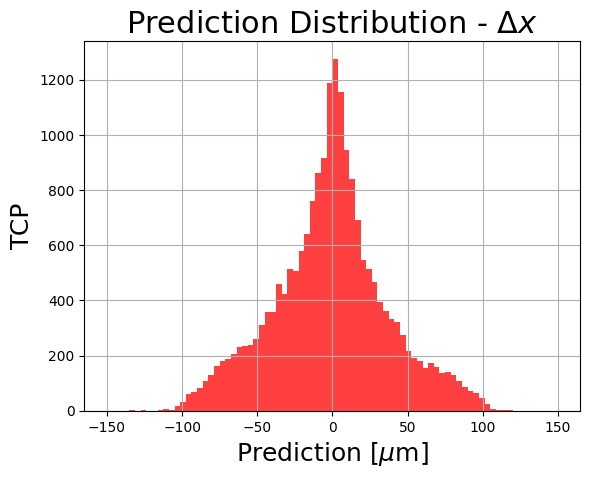

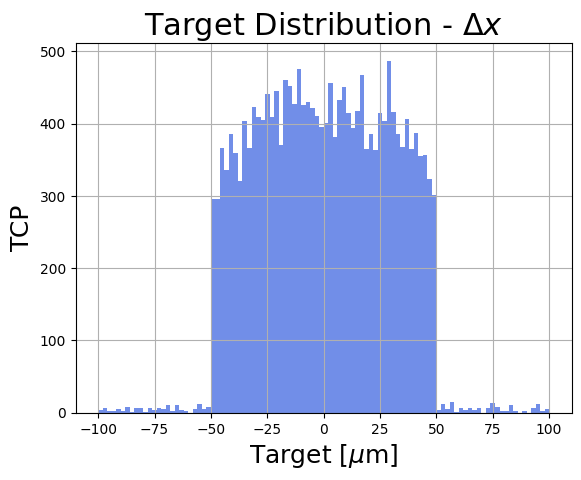

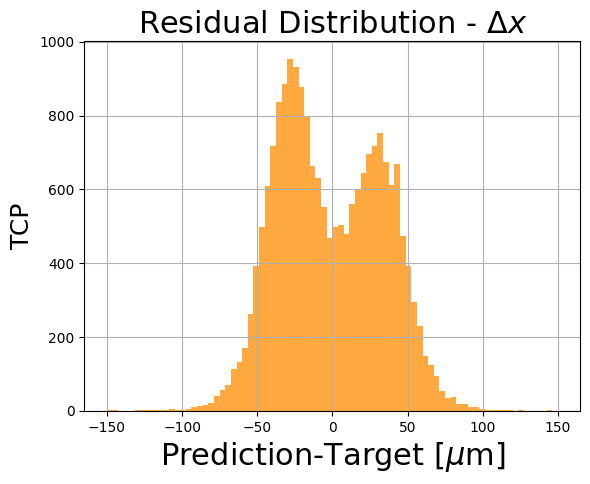

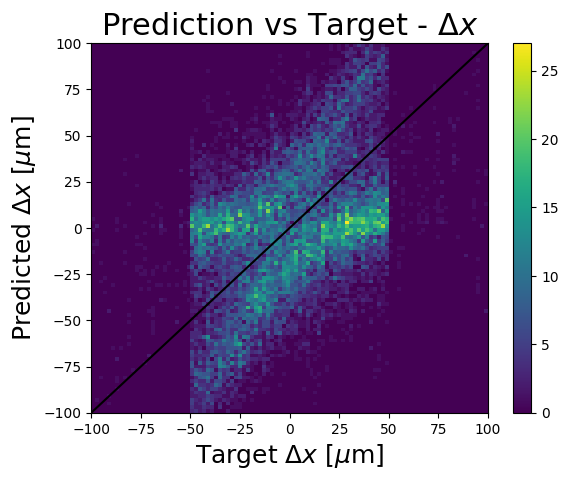

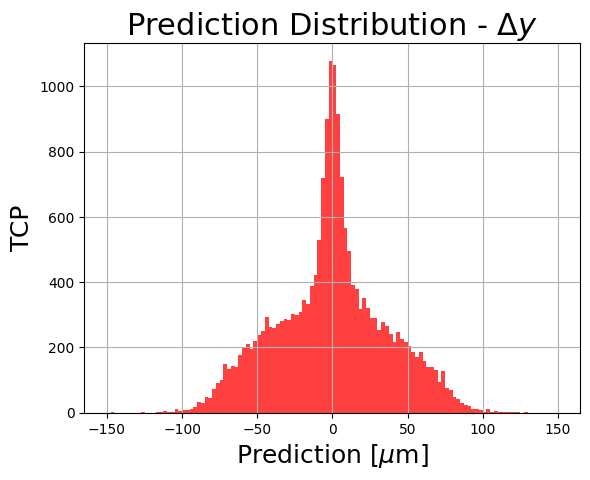

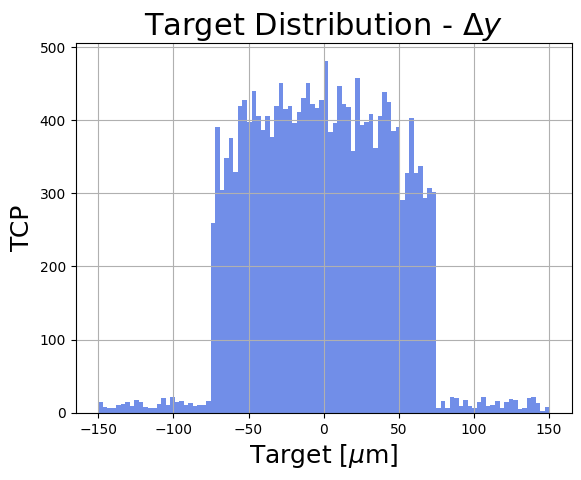

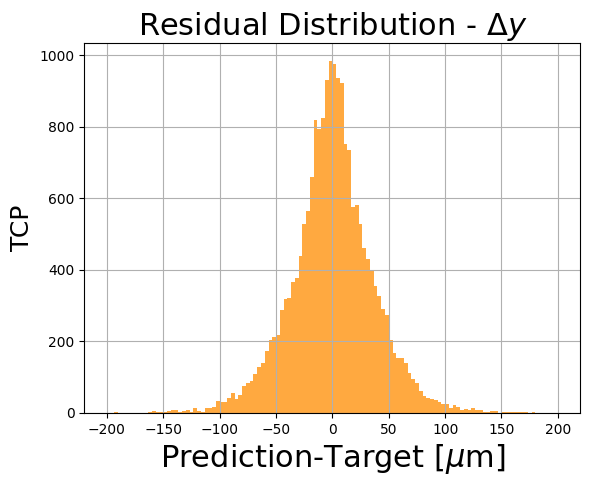

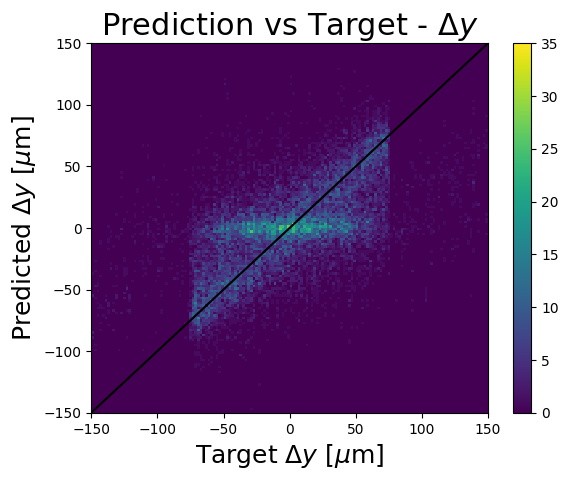

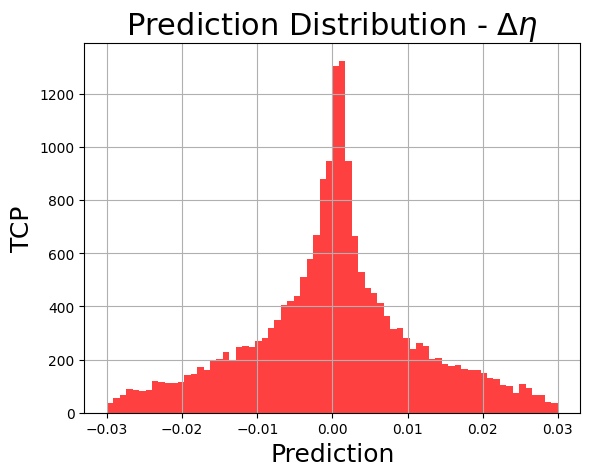

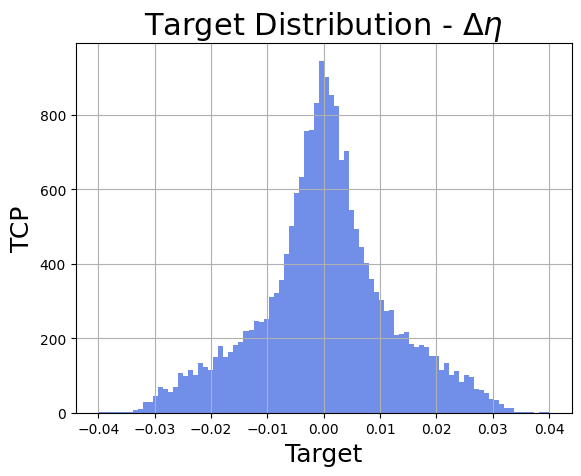

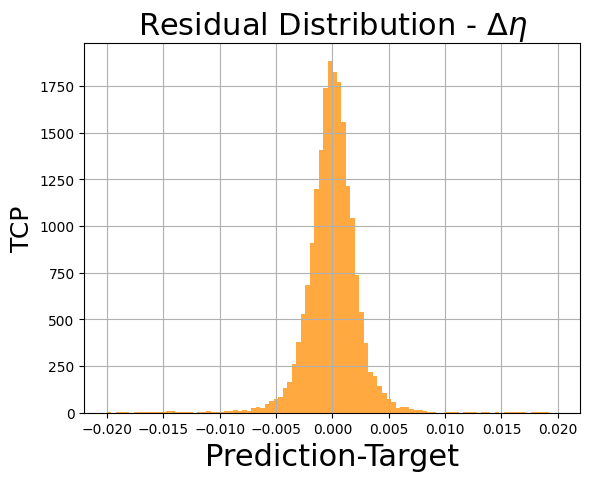

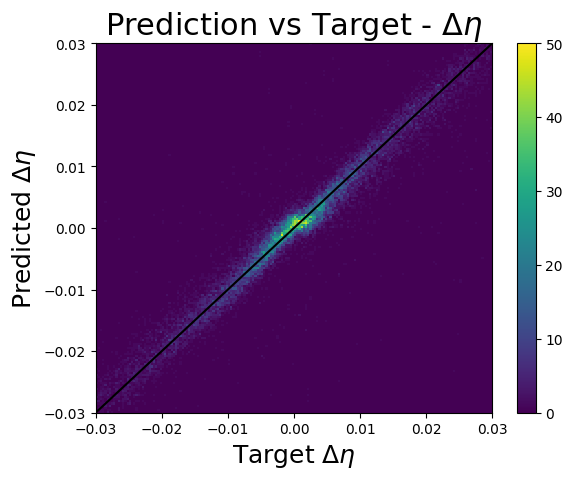

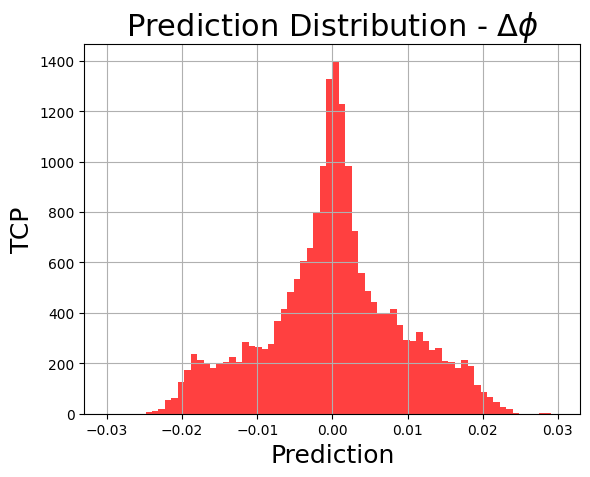

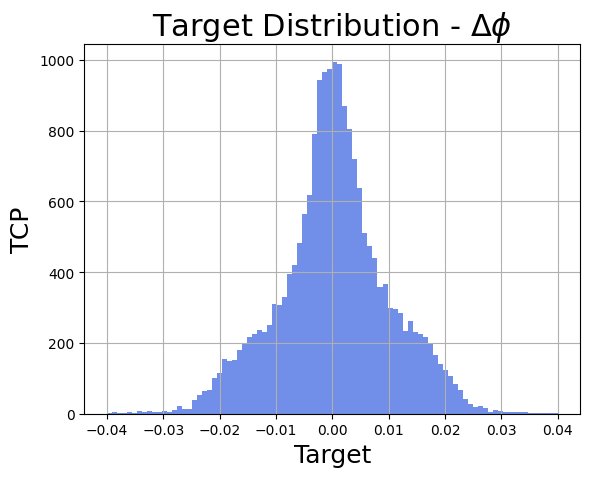

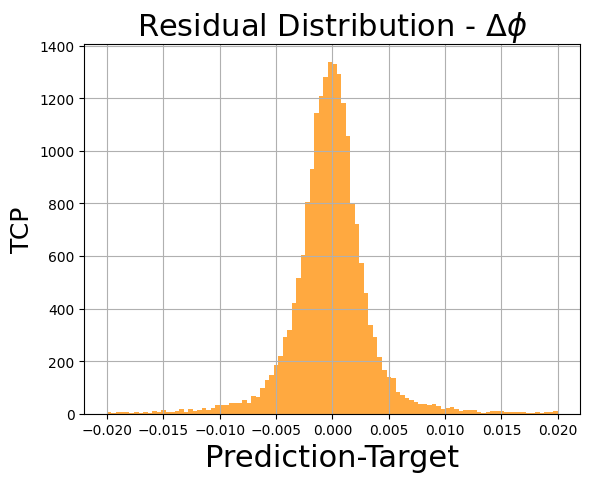

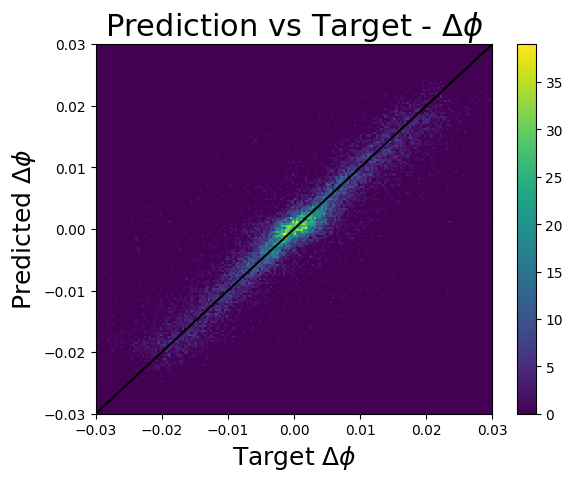

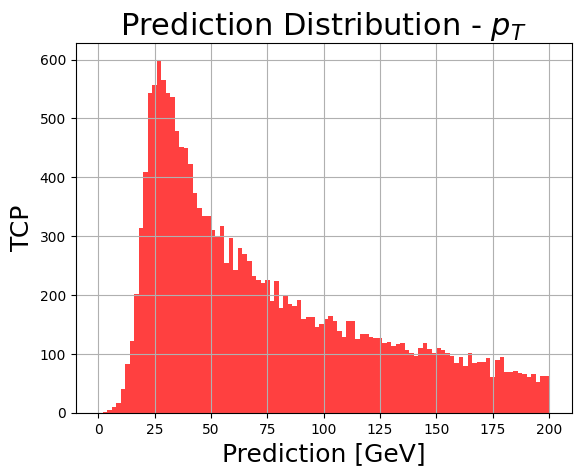

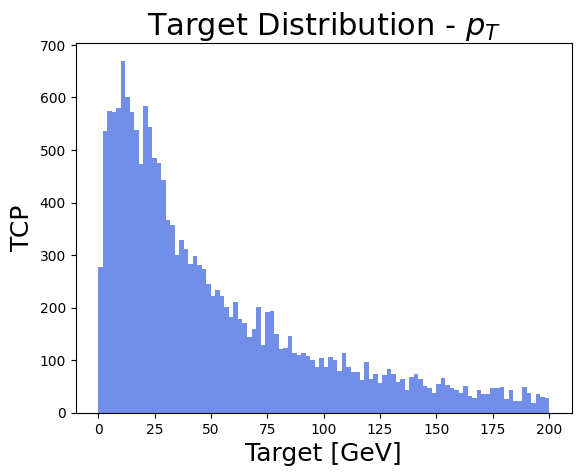

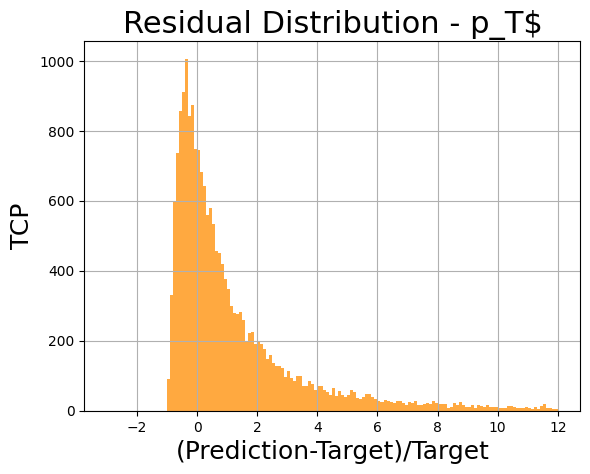

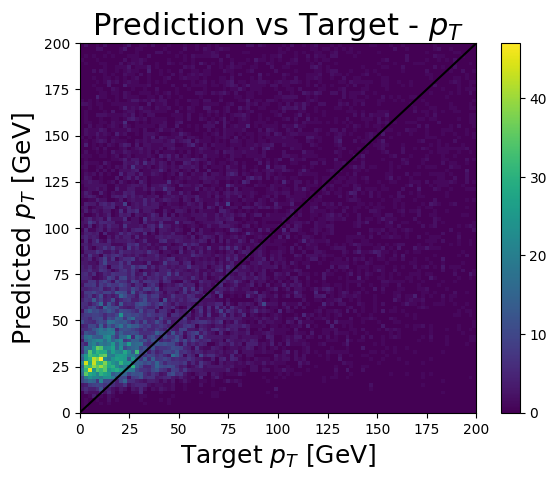

<Figure size 640x480 with 0 Axes>

In [12]:
for n in range(0,5):
    pred_plots(n,pbins_pred[n])
    plt.figure()
    target_plots(n, pbins_target[n])
    plt.figure()
    residual_plots(n,pbins[n])
    plt.figure()
    scatter_plots(n, pbins_target[n], pbins_pred[n])
    
    #target_plots(n, pbins_target[n])
    #pred_plots(n, pbins_pred[n])
    plt.figure()
#pred_plots(3, pbins_pred[3])
#plt.figure()
#target_plots(1, pbins_target[1])
#plt.figure()
#residual_plots(4, pbins[4])
#plt.figure()

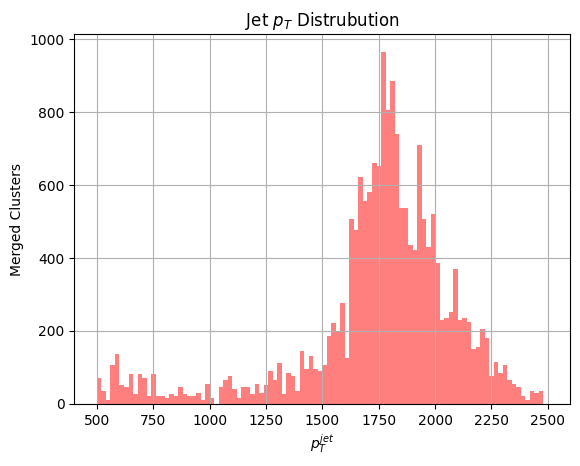

In [13]:
# jet pt distribution
bins_pt = 100
plt.hist(jet_pt, bins=bins_pt, color='r', range = (500, 2500), alpha=0.5)
plt.title('Jet $p_T$ Distrubution')
plt.xlabel('$p_T^{jet}$')
plt.ylabel('Merged Clusters')
plt.grid(True)
plt.show()

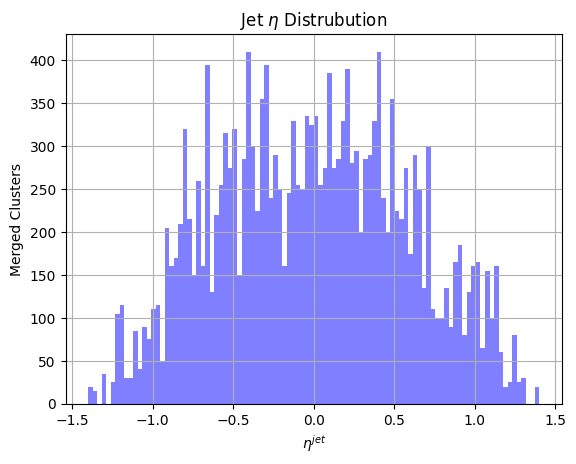

In [14]:
# jet eta distribution
bins_eta = 100
plt.hist(jet_eta, bins=bins_eta, color='b', range = (-1.4, 1.4), alpha=0.5)
plt.title('Jet $\eta$ Distrubution')
plt.xlabel('$\eta^{jet}$')
plt.ylabel('Merged Clusters')
plt.grid(True)
plt.show()

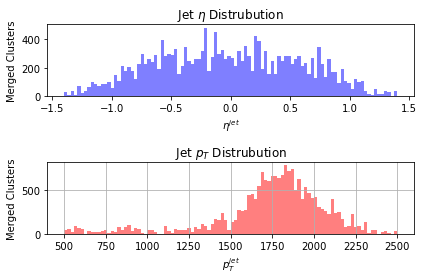

In [33]:
# jet pt and eta plotted together (I prefer separately)
bins_eta = 100
bins_pt = 100
fig, (j_eta, j_pt) = plt.subplots(2, 1)

j_eta.hist(jet_eta, bins=bins_eta, color='b',range = (-1.4,1.4), alpha=0.5)
j_eta.set_title('Jet $\eta$ Distrubution')
j_eta.set_xlabel('$\eta^{jet}$')
j_eta.set_ylabel('Merged Clusters')
j_pt.hist(jet_pt, bins=bins_pt, color='r', range = (500, 2500), alpha=0.5)
j_pt.set_title('Jet $p_T$ Distrubution')
j_pt.set_xlabel('$p_T^{jet}$')
j_pt.set_ylabel('Merged Clusters')
plt.tight_layout()
#plt.savefig("Jet_eta_and_pt.png")
plt.grid(True)
plt.show()

# TCP Maps

In [9]:
OUTPUT = True
PREDICT = False
ON_DATA = False
DRAW_ONLY = False
RGB = True

valSplit=0.2
numPrint =1 #number of event saved in the root file
outEvent= 30

input_ = chunk[0][0]
input_jeta = chunk[0][1]
input_jpt = chunk[0][2]
target_ = chunk[1][0]
target_prob = chunk[1][1]


# linear propagation to the 4 barrel layers, with plotting purpose only
def prop_on_layer(x1,y1,eta,phi,eta_jet,lay) :

    theta_jet = 2*math.atan(math.exp(-eta_jet))
    eta = eta+eta_jet
    theta = 2*math.atan(math.exp(-eta))

    if(lay==0) :
        dist=2.9-6.8
    if(lay==1) :
        dist=6.8-6.8
    if(lay==2) :
        dist=10.9-6.8
    if(lay==3) :
        dist=16-6.8
    distx=dist/0.01
    disty=dist/0.015

    y_out = disty*math.sin(theta-theta_jet)/(math.sin(theta_jet)*math.sin(theta))+y1
    x_out = distx*math.tan(-phi)+x1

    return (x_out,y_out)
    

In [10]:
if OUTPUT :
    import ROOT
    from ROOT import gStyle
    from ROOT import gROOT, TColor, TAxis
    gROOT.Reset()
    gROOT.SetBatch(True)
    gStyle.SetOptStat(0)
    validation_offset=int(len(input_)*(1-valSplit)+1)

    canvasTot = []
    canvasProb = []

    mapTot = []
    graphTargetTot = []
    mapProbPredTot = []
    graphPredTot = []


    for jet in range(numPrint) :

        canvasTot_jet = []
        mapTot_jet = []
        graphTargetTot_jet = []
        canvasProb_jet =[]
        mapProbPredTot_jet =[]
        graphPredTot_jet = []


        for trk in range(overlapNum) :
            canvasProb_jet.append(ROOT.TCanvas("canvasProb_%d_%d" % (jet,trk), "canvasProb_%d_%d" % (jet,trk),500,800))
            mapProbPredTot_jet.append(ROOT.TH2F("mapProbPredTot_%d_%d" % (jet,trk), "mapProbPredTot_%d_%d" % (jet,trk), jetDim,-jetDim/2,jetDim/2,jetDim,-jetDim/2,jetDim/2))

        for lay in range(layNum) :
            mapTot_jet.append(ROOT.TH2F("mapTot_%d_%d" % (jet, lay), "mapTot_%d_%d" % (jet, lay), jetDim,-jetDim/2,jetDim/2,jetDim,-jetDim/2,jetDim/2))
            canvasTot_jet.append(ROOT.TCanvas("canvasTot_%d_%d" % (jet, lay), "canvasTot_%d_%d" % (jet, lay),500,800))
            graphTargetTot_jet.append(ROOT.TGraph())
            #  graphPredTot_jet.append(ROOT.TGraph(overlapNum*3))
            graphPredTot_jet.append(ROOT.TGraph())

        mapTot.append(mapTot_jet)
        
        canvasTot.append(canvasTot_jet)
        graphTargetTot.append(graphTargetTot_jet)
        mapProbPredTot.append(mapProbPredTot_jet)
        canvasProb.append(canvasProb_jet)
        graphPredTot.append(graphPredTot_jet)




    for jet in range(numPrint) :
        print("=================================== New Event ======================================")

        j_eff = jet+validation_offset
        #  j_eff = jet #WARNING, is this intended? 

        #check if lay1 is broken
        brokenLay_flag = False
        brokenLay_cut = 0
        for x in range(jetDim) :
            for y in range(jetDim) :
                if(input_[j_eff][x][y][1] > 0.0001) :
                    brokenLay_flag = True
        if(not brokenLay_flag) :
            brokenLay_cut = 0.35

         # fill the histos   
        for lay in range(layNum) :
            tarPoint = 0
            predPoint = 0
            graphPredTot[jet][lay].SetMarkerColor(7)
            graphPredTot[jet][lay].SetMarkerStyle(28)
            graphPredTot[jet][lay].SetMarkerSize(3)
            graphTargetTot[jet][lay].SetMarkerColor(6)
            graphTargetTot[jet][lay].SetMarkerStyle(2)
            graphTargetTot[jet][lay].SetMarkerSize(3)
            for x in range(jetDim) :
                for y in range(jetDim) :
                    mapTot[jet][lay].SetBinContent(x+1,y+1,input_[j_eff][x][y][lay])
                    if(input_[j_eff][x][y][lay]>0) : print("input pixel:", "(x,y)=",x,y, ", layer=",lay, ", value=", input_[j_eff][x][y][lay])
                    for trk in range(overlapNum) :
                        if not DRAW_ONLY : 
                            mapProbPredTot[jet][trk].SetBinContent(x+1,y+1,validation_prob[j_eff][x][y][trk][0])
                        if(not ON_DATA) :
                            if target_prob[j_eff][x][y][trk][0] == 1 and lay==1: # check this
                                xx= float(target_[j_eff][x][y][trk][0])/float(0.01)*0.01#normaliz. factor
                                yy= float(target_[j_eff][x][y][trk][1])/float(0.015)*0.01
                                graphTargetTot[jet][lay].SetPoint(tarPoint,x+xx-jetDim/2,y+yy-jetDim/2)

                                x0,y0 = prop_on_layer(x+xx-jetDim/2, y+yy-jetDim/2,target_[j_eff][x][y][trk][2]*0.01,target_[j_eff][x][y][trk][3]*0.01,input_jeta[j_eff],0)
                                x2,y2 = prop_on_layer(x+xx-jetDim/2, y+yy-jetDim/2,target_[j_eff][x][y][trk][2]*0.01,target_[j_eff][x][y][trk][3]*0.01,input_jeta[j_eff],2)
                                x3,y3 = prop_on_layer(x+xx-jetDim/2, y+yy-jetDim/2,target_[j_eff][x][y][trk][2]*0.01,target_[j_eff][x][y][trk][3]*0.01,input_jeta[j_eff],3)
                                graphTargetTot[jet][0].SetPoint(tarPoint,x0,y0)
                                graphTargetTot[jet][2].SetPoint(tarPoint,x2,y2)
                                graphTargetTot[jet][3].SetPoint(tarPoint,x3,y3)
                                tarPoint = tarPoint+1
                        if not DRAW_ONLY :
                            if validation_prob[j_eff][x][y][trk][0] > (prob_thr-0.1*trk-brokenLay_cut) and lay==1 : #and   target_prob[j_eff][x][y][trk] == 1: #this is an useful option to debug
                                xx_pr= float(validation_par[j_eff][x][y][trk][0])/float(0.01)*0.01
                                yy_pr= float(validation_par[j_eff][x][y][trk][1])/float(0.015)*0.01
                                graphPredTot[jet][lay].SetPoint(predPoint,x+xx_pr-jetDim/2,y+yy_pr-jetDim/2)

                                x0,y0 = prop_on_layer(x+xx_pr-jetDim/2, y+yy_pr-jetDim/2,validation_par[j_eff][x][y][trk][2]*0.01,validation_par[j_eff][x][y][trk][3]*0.01,input_jeta[j_eff],0)
                                x2,y2 = prop_on_layer(x+xx_pr-jetDim/2, y+yy_pr-jetDim/2,validation_par[j_eff][x][y][trk][2]*0.01,validation_par[j_eff][x][y][trk][3]*0.01,input_jeta[j_eff],2)
                                x3,y3 = prop_on_layer(x+xx_pr-jetDim/2, y+yy_pr-jetDim/2,validation_par[j_eff][x][y][trk][2]*0.01,validation_par[j_eff][x][y][trk][3]*0.01,input_jeta[j_eff],3)
                                graphPredTot[jet][0].SetPoint(predPoint,x0,y0)
                                graphPredTot[jet][2].SetPoint(predPoint,x2,y2)
                                graphPredTot[jet][3].SetPoint(predPoint,x3,y3)
                                predPoint = predPoint+1

                                print("________________________________________")
                                print("New Pred, bin (x,y):",x-jetDim/2,y-jetDim/2)
                                if(not ON_DATA):
                                    print("target(x,y,eta,phi)=",target_[j_eff][x][y][trk][0]," ", target_[j_eff][x][y][trk][1]," ",target_[j_eff][x][y][trk][2]," ",target_[j_eff][x][y][trk][3]," ",target_[j_eff][x][y][trk][4],"Probabiity target=", target_prob[j_eff][x][y][trk])
                                    print("prediction(x,y,eta,phi)=",validation_par[j_eff][x][y][trk][0]," ", validation_par[j_eff][x][y][trk][1]," ",validation_par[j_eff][x][y][trk][2]," ",validation_par[j_eff][x][y][trk][3]," ",validation_par[j_eff][x][y][trk][4], "Probabiity pred=", validation_prob[j_eff][x][y][trk])
                                    print(" x0,y0=",x0,y0," x2,y2=",x2,y2," x3,y3=",x3,y3,)


    output_file = ROOT.TFile("DeepCore_mapValidation.root","recreate")
    from array import array as array2

    if(RGB) : #set the color scheme

        NCont=10

        array_of_palette = []
        palette = []

        Red =[1.,1.]
        Green =[1.,0.]
        Blue =[1.,0.]
        Stops =[0.,1.]
        StopsArray = array2('d', Stops)
        RedArray = array2('d', Red)
        GreenArray = array2('d', Green)
        BlueArray = array2('d', Blue)
        FI = TColor.CreateGradientColorTable(2, StopsArray, RedArray, GreenArray, BlueArray, NCont)
        for i in range(0,NCont) :
            palette.append(FI+i)
        paletteArray = array2('i',palette)
        palette[:]=[]
        array_of_palette.append(paletteArray)


        Red =[1.,0.]
        Green =[1.,0.]
        Blue =[1.,0.]
        Stops =[0.,1.]
        StopsArray = array2('d', Stops)
        RedArray = array2('d', Red)
        GreenArray = array2('d', Green)
        BlueArray = array2('d', Blue)
        FI = TColor.CreateGradientColorTable(2, StopsArray, RedArray, GreenArray, BlueArray, NCont)
        for i in range(0,NCont) :
            palette.append(FI+i)
        paletteArray = array2('i',palette)
        palette[:]=[]
        array_of_palette.append(paletteArray)

        Red =[1.,0]
        Green =[1.,1]
        Blue =[1.,0.]
        Stops =[0.,1.]
        StopsArray = array2('d', Stops)
        RedArray = array2('d', Red)
        GreenArray = array2('d', Green)
        BlueArray = array2('d', Blue)
        FI = TColor.CreateGradientColorTable(2, StopsArray, RedArray, GreenArray, BlueArray, NCont)
        for i in range(0,NCont) :
            palette.append(FI+i)
        paletteArray = array2('i',palette)
        palette[:]=[]
        array_of_palette.append(paletteArray)

        Red =[1.,0.]
        Green =[1.,0.]
        Blue =[1.,1.]
        Stops =[0.,1.]
        StopsArray = array2('d', Stops)
        RedArray = array2('d', Red)
        GreenArray = array2('d', Green)
        BlueArray = array2('d', Blue)
        FI = TColor.CreateGradientColorTable(2, StopsArray, RedArray, GreenArray, BlueArray, NCont)
        for i in range(0,NCont) :
            palette.append(FI+i)
        paletteArray = array2('i',palette)
        palette[:]=[]
        array_of_palette.append(paletteArray)

     # build the canvases
    for jet in range(numPrint) :

         #check if lay1 is broken!
        brokenLay_flag = False
        brokenLay_cut = 0
        for x in range(jetDim) :
            for y in range(jetDim) :
                if(input_[jet][x][y][1] > 0.0001) :
                    brokenLay_flag = True
        if(not brokenLay_flag) :
            brokenLay_cut = 0.35
        

        for lay in range(layNum) :
            canvasTot[jet][lay].cd()
            mapTot[jet][lay].GetXaxis().SetRangeUser(-jetDim,jetDim)
            mapTot[jet][lay].GetYaxis().SetRangeUser(-jetDim,jetDim)
            #  mapTot[jet][lay].SetTitle("Pixel Map, cluster %d, layer %d, pt=%f, eta=%f" % (jet, lay+1, input_jpt[jet],input_jeta[jet]))
            mapTot[jet][lay].SetTitle("Pixel Window, layer %d" % (lay+1))
            mapTot[jet][lay].GetXaxis().SetTitle("x [pixel]")
            mapTot[jet][lay].GetYaxis().SetTitle("y [pixel]")
            mapTot[jet][lay].GetYaxis().SetTitleOffset(1)
            mapTot[jet][lay].GetZaxis().SetTitle("ADC count [/14k]")
            mapTot[jet][lay].GetZaxis().SetTitleOffset(-1.05)
            mapTot[jet][lay].GetXaxis().SetTitleSize(0.06)
            mapTot[jet][lay].GetYaxis().SetTitleSize(0.06)
            mapTot[jet][lay].GetZaxis().SetTitleSize(0.04)
            mapTot[jet][lay].GetXaxis().SetTitleOffset(0.7)
            mapTot[jet][lay].GetYaxis().SetTitleOffset(0.6)

            latexCMS = ROOT.TLatex()


            if(not RGB) :
                mapTot[jet][lay].Draw("colz")

                latexCMS.SetTextSize(0.05)
                latexCMS.DrawLatex(-16.2,16.2,"#bf{#bf{CMS}} #scale[0.7]{#bf{#it{Simulation Preliminary}}}")
                latexCMS.DrawLatex(12,16.2,"#bf{13 TeV}")

            else :
                gStyle.SetPalette(NCont,array_of_palette[lay])
                mapTot[jet][lay].Draw("colz")

                latexCMS.SetTextSize(0.05)
                latexCMS.DrawLatex(-16.2,16.2,"#bf{#bf{CMS}} #scale[0.7]{#bf{#it{Simulation Preliminary}}}")
                latexCMS.DrawLatex(12,16.2,"#bf{13 TeV}")

            if(jet==outEvent and RGB):


                mapTot[jet][lay].GetZaxis().SetRangeUser(0,2.7)
                canvasTot[jet][lay].SaveAs("RGB_PixelMap_input_layer%d_event%d.pdf" % (lay,jet))
                canvasTot[jet][lay].SaveAs("RGB_PixelMap_input_layer%d_event%d.png" % (lay,jet))

            if (not ON_DATA) :
                graphTargetTot[jet][lay].Draw("SAME P")
            graphPredTot[jet][lay].Draw("SAME P")

            graphTargetTot[jet][lay].SetLineColor(0)
            graphPredTot[jet][lay].SetLineColor(0)
            graphTargetTot[jet][lay].SetFillColor(0)
            graphPredTot[jet][lay].SetFillColor(0)

            latexCMS.SetTextSize(0.05)
            latexCMS.DrawLatex(-16.2,16.2,"#bf{#bf{CMS}} #scale[0.7]{#bf{#it{Simulation Preliminary}}}")
            latexCMS.DrawLatex(12,16.2,"#bf{13 TeV}")



            legTot = ROOT.TLegend(0.1,0.9,0.3,0.8);
            if (not ON_DATA) :
                legTot.AddEntry(graphTargetTot[jet][lay], "Target")
            legTot.AddEntry(graphPredTot[jet][lay], "Prediction")
            legTot.SetTextSize(0.03);
            legTot.Draw("SAME")

            canvasTot[jet][lay].Write()

            if(jet==outEvent and RGB):
                canvasTot[jet][lay].SaveAs("RGB_PixelMap_crosses_layer%d_event%d.pdf" % (lay,jet))
                canvasTot[jet][lay].SaveAs("RGB_PixelMap_crosses_layer%d_event%d.png" % (lay,jet))

        for trk in range(overlapNum) :
            canvasProb[jet][trk].cd()
            mapProbPredTot[jet][trk].GetXaxis().SetRangeUser(-jetDim,jetDim)
            mapProbPredTot[jet][trk].GetYaxis().SetRangeUser(-jetDim,jetDim)
            gStyle.SetPalette(57)
            mapProbPredTot[jet][trk].Draw("colz")
            mapProbPredTot[jet][trk].GetXaxis().SetTitle("x [pixel]")
            mapProbPredTot[jet][trk].GetYaxis().SetTitle("y [pixel]")
            mapProbPredTot[jet][trk].GetYaxis().SetTitleOffset(1.2)
            #  mapProbPredTot[jet][trk].SetTitle("TCP Prediction Map, cluster %d, overlap %d" % (jet, trk))
            mapProbPredTot[jet][trk].SetTitle("TCP Prediction Map, overlap %d" % (trk))
            mapProbPredTot[jet][trk].GetZaxis().SetTitle("Probability")
            mapProbPredTot[jet][trk].GetZaxis().SetTitleOffset(-1.05)
            mapProbPredTot[jet][trk].GetXaxis().SetTitleSize(0.06)
            mapProbPredTot[jet][trk].GetYaxis().SetTitleSize(0.06)
            mapProbPredTot[jet][trk].GetXaxis().SetTitleOffset(0.7)
            mapProbPredTot[jet][trk].GetYaxis().SetTitleOffset(0.6)
            if (not ON_DATA) :
                graphTargetTot[jet][1].Draw("SAME P")
            graphPredTot[jet][1].Draw("SAME P")

            latexCMS.SetTextSize(0.05)
            latexCMS.DrawLatex(-16.2,16.2,"#bf{#bf{CMS}} #scale[0.7]{#bf{#it{Simulation Preliminary}}}")
            latexCMS.DrawLatex(12,16.2,"#bf{13 TeV}")


            legProb = ROOT.TLegend(0.1,0.9,0.3,0.8);
            if (not ON_DATA) :
                legProb.AddEntry(graphTargetTot[jet][1], "Target")
            legProb.AddEntry(graphPredTot[jet][1], "Prediction")
            legProb.SetTextSize(0.03);
            legProb.Draw("SAME")

            mapProbPredTot[jet][0].GetZaxis().SetRangeUser(0,1)
            canvasProb[jet][trk].Write()

        if(jet==outEvent and RGB):
            canvasProb[jet][0].SaveAs("Probabiltiy_crosses_event%d.pdf" % (jet))#.png
            canvasProb[jet][0].SaveAs("Probabiltiy_crosses_event%d.png" % (jet))#.png

    output_file.Close()

Welcome to JupyROOT 6.28/00
=================================== New Event ======================================
input pixel: (x,y)= 1 23 , layer= 0 , value= 0.34150001406669617
input pixel: (x,y)= 2 23 , layer= 0 , value= 2.6882143020629883
input pixel: (x,y)= 2 27 , layer= 0 , value= 1.5953571796417236
input pixel: (x,y)= 4 23 , layer= 0 , value= 0.27142858505249023
input pixel: (x,y)= 5 23 , layer= 0 , value= 1.711571455001831
input pixel: (x,y)= 6 28 , layer= 0 , value= 0.4186428487300873
input pixel: (x,y)= 7 19 , layer= 0 , value= 1.1257143020629883
input pixel: (x,y)= 7 28 , layer= 0 , value= 1.3351428508758545
input pixel: (x,y)= 8 19 , layer= 0 , value= 2.6471428871154785
input pixel: (x,y)= 8 20 , layer= 0 , value= 0.3651428520679474
input pixel: (x,y)= 9 20 , layer= 0 , value= 0.29007142782211304
input pixel: (x,y)= 12 22 , layer= 0 , value= 0.30628570914268494
input pixel: (x,y)= 13 22 , layer= 0 , value= 0.9373571276664734
input pixel: (x,y)= 13 23 , layer= 0 , value= 0.47

# Minor bug: 

you need restart kernel after displaying TCP maps, will fix in the future (or feel free to implement a fix yourself)

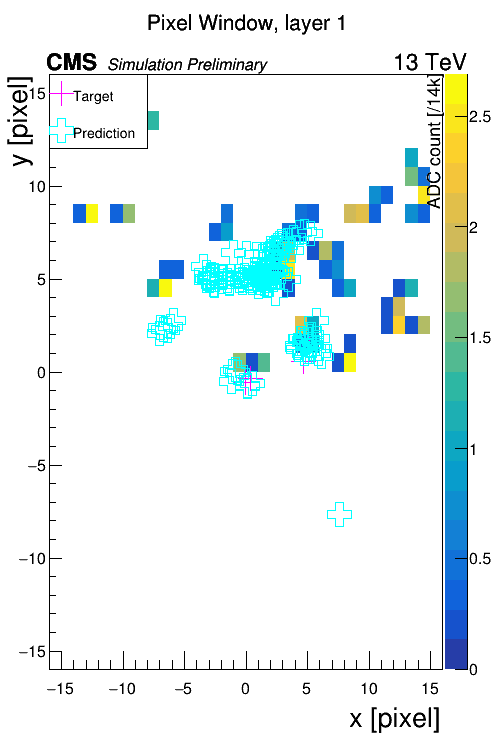

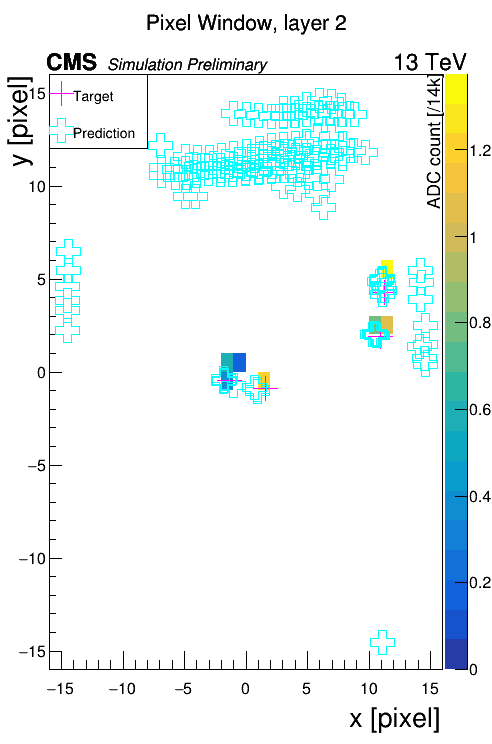

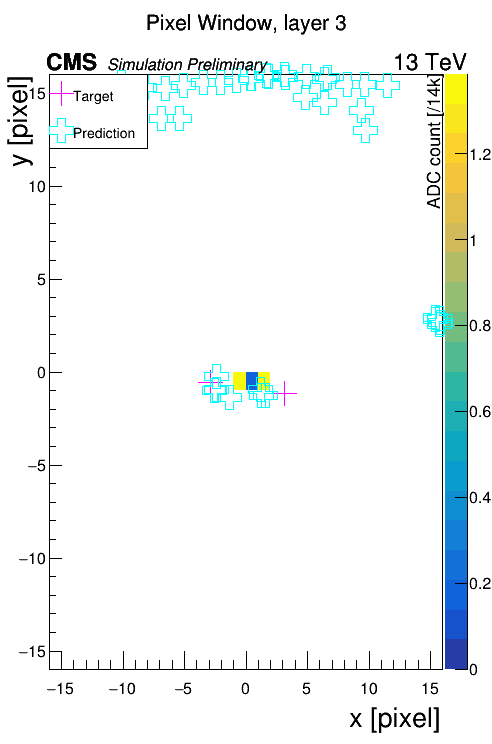

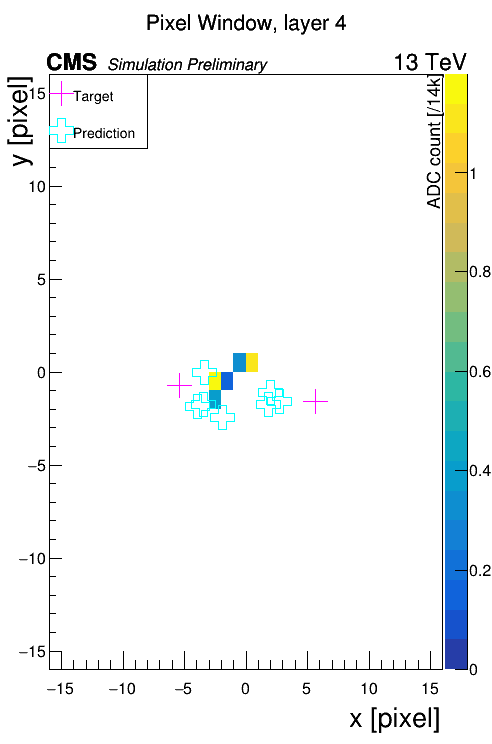

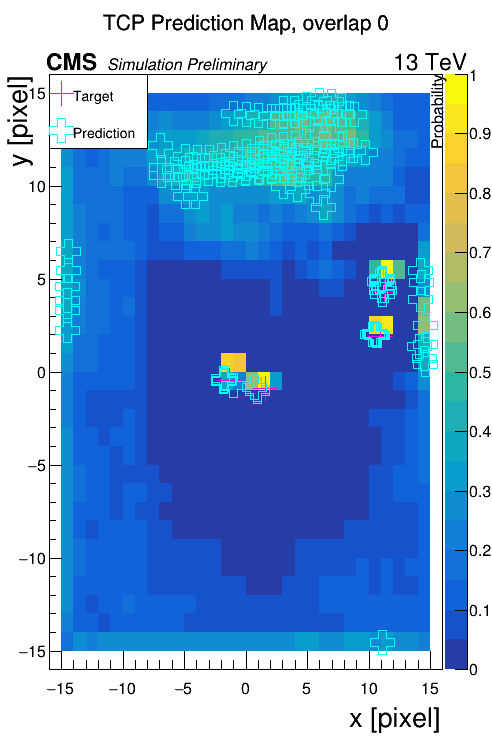

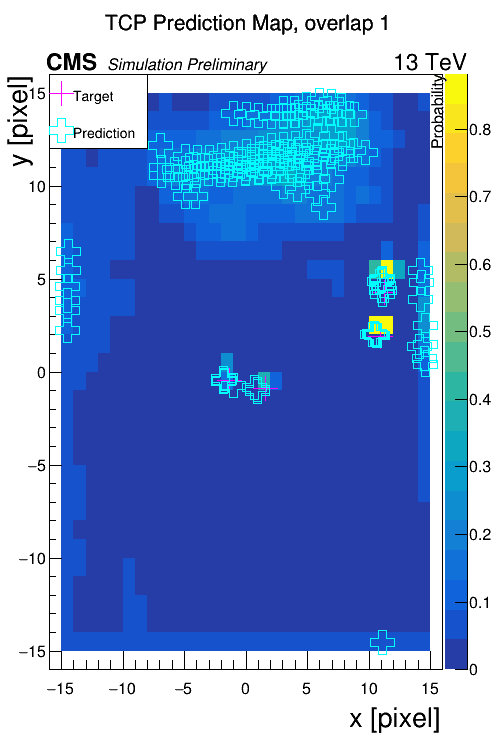

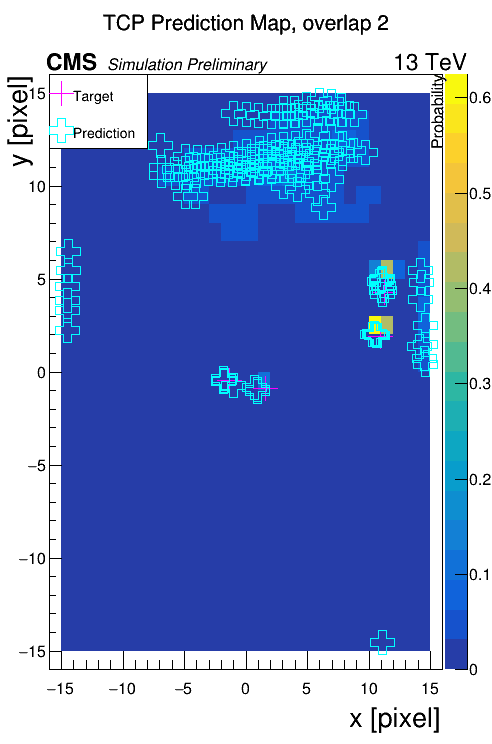

In [ ]:
# Displays TCP Maps
import ROOT
from IPython.display import Image
from IPython.display import display

file_path = "DeepCore_mapValidation.root"


root_file = ROOT.TFile.Open(file_path, "READ")

# Check if the file was opened successfully
if not root_file or root_file.IsZombie():
    print(f"Error: Unable to open file '{file_path}'")
        
# Get the list of keys (objects) in the file
list_of_keys = root_file.GetListOfKeys()

# Loop over the keys
for key in list_of_keys:
    obj = key.ReadObj()
    if isinstance(obj, ROOT.TCanvas):
        # Display the canvas
        obj.Draw()
        obj.SaveAs(obj.GetName() + ".png")
        display(Image(obj.GetName() + ".png"))

# Keep canvases displayed until the user closes them
#ROOT.gApplication.Run()

#display(Image("hist.png"))
# Close the file when you are done
root_file.Close()

# Experimental Stuff
Ignore the plots below, I'm just trying stuff

In [ ]:
# PLot Threshold plot
fpr_keras, tpr_keras, _ = metrics.roc_curve(truth, pred)
S = len(signal_a)*tpr_keras
B = len(background_a)*fpr_keras
metric = S/np.sqrt(S+B)

plt.plot(_, metric)
xmax = _[np.argmax(metric)]
ymax = metric.max()
print(xmax, ymax)
plt.xlabel('Threshold value')
plt.ylabel('$\\frac{S}{\\sqrt{S+B}}$')
plt.xlim(0, 1.0)

In [ ]:
# Accessing .npz files with predictions

import numpy as np
from numpy import load
from IPython.display import Image
from IPython.display import display

data = load('Prediction.npz')
lst = data.files
for item in lst:
    print(item)
    #print(data[item][0])


DT = data["validation_prob"][:10,:,:,:,:]
# DT.dtype
# DT.shape
DT = DT[:,:,:,:,:-1]
DT.shape  

# Random plots

In [ ]:
# Removing duplicates: not needed here

sigf = []
for i in range(len(signal)):
    x = [signal_target[i][0],signal_target[i][1], signal_target[i][2], signal_target[i][3],signal_target[i][4],signal[i]]
    sigf.append(x)
    
for i in range(20):
    print(signal_target[i][4], signal[i])
    print(sigf[i])
    print("*********")
    
from operator import itemgetter
sigf_sorted = sorted(sigf, key = itemgetter(2))

for i in range(50):
    print(sigf_sorted[i])

sig_nodup = []
sig_nodup.append(sigf_sorted[0])
for i in range(1,len(sigf_sorted)):
        if (sigf_sorted[i][2] == sigf_sorted[i-1][2]):

        if not (sigf_sorted[i][2] == sigf_sorted[i-1][2]):
            sig_nodup.append(sigf_sorted[i])
        
for i in range(50):
    print(sig_nodup[i])
    
signal_pred = []
for i in range(len(sig_nodup)):
        signal_pred.append(sig_nodup[i][5])
        
print(len(sig_nodup), len(sigf_sorted))


In [ ]:
# Accessing h5 files nodes and weights
import h5py
hf_in = h5py.File('Valerio_model.hdf5', 'r')
hf_in1 = h5py.File('T0628.h5', 'r')

print(list(hf_in.keys()))
print(list(hf_in1.keys()))

model_w = hf_in['model_weights']
model_w1 = hf_in1['model_weights']
L1 = list(model_w.keys())
L2 = list(model_w1.keys())

print("Valerio_______Hichem")
for i in range(len(L1)):
    print(L1[i], L2[i])
    
model_o = hf_in['optimizer_weights']
model_o1 = hf_in1['optimizer_weights']
print(list(model_o.keys()))
print(list(model_o1.keys()))
tra = model_o['training']
print(list(tra.keys()))
tra2 = tra['Adam']
print(list(tra2.keys()))
dir(tra2.values())
tra2.__format__

In [ ]:
# Plot Delta pred(trk(j) - trk(j))
signal = []
background = []

N = 3700 # number of inputs
Nx = 30 # X dimension
Ny = 30 # Y dimension
Ntrk = 3 # Number of tracks

for i in range(N):
    for j in range(Nx):
        for k in range(Ny):
             if chunk[1][1][i][j][k][0][0] ==0:
                signal.append(validation_prob[i,j,k,0,0]-validation_prob[i,j,k,1,0])  
                background.append(validation_prob[i,j,k,1,0]-validation_prob[i,j,k,2,0]) 
               

            
bin_size = 1000
plt.hist(signal, alpha = 0.5, color = 'b', label = '$\Delta$(trk1 - trk2)', range = (-0.1,0.4), bins = bin_size, density = True)
plt.hist(background, alpha = 0.5, color = 'r', label = '$\Delta$(trk2 - trk3)', range = (-0.1,0.4), bins = bin_size, density = True)
plt.legend(loc='best')
plt.xlabel('$\Delta$ Prediction Score ')
plt.ylabel('Predicted Tracks')
plt.title('$\Delta$ Prediction Score Distribution')
plt.show()

In [ ]:
# Plot trk1 score by whether there are 1, 2 or 3 true tracks
track_1 = []
track_2 = []
track_3 = []


N = 3700 # number of inputs
Nx = 30 # X dimension
Ny = 30 # Y dimension
Ntrk = 3 # Number of tracks

for i in range(N):
    for j in range(Nx):
        for k in range(Ny):
                l = 0
                if chunk[1][1][i][j][k][2][0] ==1:
                    track_3.append(validation_prob[i,j,k,l,0])
                elif chunk[1][1][i][j][k][1][0] ==1:
                    track_2.append(validation_prob[i,j,k,l,0])
                elif chunk[1][1][i][j][k][0][0] ==1:
                    track_1.append(validation_prob[i,j,k,l,0])
                    
                    
                    

bin_size = 1000
#bin_size = 50
plt.hist(track_3, alpha = 0.5, color = 'b', label = '3 True Tracks', range = (0,1), bins = bin_size, density = True)
plt.hist(track_2, alpha = 0.5, color = 'r', label = '2 True Tracks', range = (0,1), bins = bin_size, density = True)
plt.hist(track_1, alpha = 0.5, color = 'g', label = '1 True Track', range = (0,1), bins = bin_size, density = True)
plt.legend(loc='best')
plt.xlabel('Prediction Score')
plt.ylabel('Predicted Tracks for Track 1')
plt.title('Prediction Score Distribution for Track 1')
plt.show()

In [ ]:
# Calulating non charged pixel vs charge pixel ratio in layer 2

N = 3700 # number of inputs
Nx = 30 # X dimension
Ny = 30 # Y dimension
adc_0 = 0
adc = 0
for i in range(N):
    for j in range(Nx):
        for k in range(Ny):
                if chunk[0][0][i][j][k][1] ==0:
                    adc_0 = adc_0 + 1
                else:
                    adc = adc + 1

print(adc_0/adc)

In [ ]:
# Loading DeepCore model and evaluation of ALL test files
# Alternative method

model.load_weights('DeepCore_model_0622.h5') # DeepCore 2.2
inputs = []
signal = []
background = []
truth = []
pred = []
N = 0
i = 0
i_max = 5
chunk = next(Generator2(testing_path,batch,)) 

for chunk in Generator2(testing_path,batch,):
    i = i+1
    [validation_par,validation_prob] = model.predict(chunk[0])
    validation_par = np.float64(validation_par)
    N_i = len(validation_par)
    print(N_i)
    N = N + N_i
    Score_plots(signal, background, truth, pred, N_i, 2)
    #print(chunk[0][1][2])
   # if i%10 == 0:
   #     print("i= ",i)
    if i > i_max:
        break
print(len(signal))

Previous DeepCore models Architectures

In [ ]:
# DeepCore 2.0/2.1 Architecture
from keras.layers import AlphaDropout

NNinputs_jeta = Input(shape=(1,))
NNinputs_jpt = Input(shape=(1,))
NNinputsJet = concatenate([NNinputs_jeta,NNinputs_jpt])
jetReshaped = Reshape((1,1,2))(NNinputsJet)
jetUps = UpSampling2D(size=(jetDim,jetDim), data_format="channels_last")(jetReshaped)
print("jetUps=", jetUps.shape)
NNinputs = Input(shape=(jetDim,jetDim,layNum))
print("NNinputs=", NNinputs.shape)
ComplInput = concatenate([NNinputs,jetUps],axis=3)
print("ComplInput=", ComplInput.shape)

   
conv30_9 = Conv2D(50,7, data_format="channels_last", input_shape=(jetDim,jetDim,layNum+2), activation='relu',padding="same")(ComplInput)
conv30_7 = Conv2D(40,5, data_format="channels_last", activation='relu',padding="same")(conv30_9)
conv30_5 = Conv2D(40,5, data_format="channels_last", activation='relu',padding="same")(conv30_7)#
conv20_5 = Conv2D(30,5, data_format="channels_last", activation='relu',padding="same")(conv30_5)
conv15_5 = Conv2D(30,3, data_format="channels_last", activation='relu',padding="same")(conv20_5)

conv15_3_1 = Conv2D(30,3, data_format="channels_last",activation='relu', padding="same")(conv15_5)
conv15_3_2 = Conv2D(30,3, data_format="channels_last",activation='relu', padding="same")(conv15_3_1)
conv15_3_3 = Conv2D(30,3, data_format="channels_last",activation='relu', padding="same")(conv15_3_2) #(12,3)
conv15_3 = Conv2D(18,3, data_format="channels_last",padding="same")(conv15_3_3) #(12,3)
reshaped = Reshape((jetDim,jetDim,overlapNum,parNum+1))(conv15_3)

conv12_3_1 = Conv2D(30,3, data_format="channels_last", activation='relu', padding="same")(conv15_5)  #new
conv1_3_2 = Conv2D(25,3, data_format="channels_last", activation='relu', padding="same")(conv12_3_1) #drop7lb   #new
conv1_3_3 = Conv2D(20,3, data_format="channels_last", activation='relu',padding="same")(conv1_3_2) #new
conv1_3_1 = Conv2D(6,3, data_format="channels_last", activation='sigmoid', padding="same")(conv1_3_3)
reshaped_prob = Reshape((jetDim,jetDim,overlapNum,2))(conv1_3_1)

model = Model([NNinputs,NNinputs_jeta,NNinputs_jpt],[reshaped,reshaped_prob])
anubi = tf.keras.optimizers.Adam(learning_rate=0.0000001)#after epochs 252 (with septs/20 and batch_size 64)

model.compile(optimizer=anubi, loss=[loss_mse_select_clipped,loss_ROIsoft_crossentropy], loss_weights=[1,1]) #FOR LATE TRAINING
#model.compile(optimizer=anubi, loss=[loss_mse_select_clipped,loss_ROI_crossentropy], loss_weights=[1,1]) #FOR EARLY TRAINING
model.summary()


In [ ]:
# Architecture DeepCore 1.0
from keras.layers import AlphaDropout

NNinputs_jeta = Input(shape=(1,))
NNinputs_jpt = Input(shape=(1,))
NNinputsJet = concatenate([NNinputs_jeta,NNinputs_jpt])
jetReshaped = Reshape((1,1,2))(NNinputsJet)
jetUps = UpSampling2D(size=(jetDim,jetDim), data_format="channels_last")(jetReshaped)
print("jetUps=", jetUps.shape)
NNinputs = Input(shape=(jetDim,jetDim,layNum))
print("NNinputs=", NNinputs.shape)
ComplInput = concatenate([NNinputs,jetUps],axis=3)
print("ComplInput=", ComplInput.shape)

   
conv30_9 = Conv2D(50,7, data_format="channels_last", input_shape=(jetDim,jetDim,layNum+2), activation='relu',padding="same")(ComplInput)
conv30_7 = Conv2D(20,5, data_format="channels_last", activation='relu',padding="same")(conv30_9)
conv30_5 = Conv2D(20,5, data_format="channels_last", activation='relu',padding="same")(conv30_7)#
conv20_5 = Conv2D(18,5, data_format="channels_last", activation='relu',padding="same")(conv30_5)
conv15_5 = Conv2D(18,3, data_format="channels_last", activation='relu',padding="same")(conv20_5)

conv15_3_1 = Conv2D(18,3, data_format="channels_last",activation='relu', padding="same")(conv15_5)
conv15_3_2 = Conv2D(18,3, data_format="channels_last",activation='relu', padding="same")(conv15_3_1)
conv15_3_3 = Conv2D(18,3, data_format="channels_last",activation='relu', padding="same")(conv15_3_2) #(12,3)
conv15_3 = Conv2D(18,3, data_format="channels_last",padding="same")(conv15_3_3) #(12,3)
reshaped = Reshape((jetDim,jetDim,overlapNum,parNum+1))(conv15_3)

conv12_3_1 = Conv2D(12,3, data_format="channels_last", activation='relu', padding="same")(conv15_5)  #new
conv1_3_2 = Conv2D(9,3, data_format="channels_last", activation='relu', padding="same")(conv12_3_1) #drop7lb   #new
conv1_3_3 = Conv2D(7,3, data_format="channels_last", activation='relu',padding="same")(conv1_3_2) #new
conv1_3_1 = Conv2D(6,3, data_format="channels_last", activation='sigmoid', padding="same")(conv1_3_3)
reshaped_prob = Reshape((jetDim,jetDim,overlapNum,2))(conv1_3_1)

model = Model([NNinputs,NNinputs_jeta,NNinputs_jpt],[reshaped,reshaped_prob])
anubi = tf.keras.optimizers.Adam(learning_rate=0.00001)#after epochs 252 (with septs/20 and batch_size 64)

#model.compile(optimizer=anubi, loss=[loss_mse_select_clipped,loss_ROIsoft_crossentropy], loss_weights=[1,1]) #FOR LATE TRAINING
model.compile(optimizer=anubi, loss=[loss_mse_select_clipped,loss_ROI_crossentropy], loss_weights=[1,1]) #FOR EARLY TRAINING
model.summary()
